In [1]:
import sys
if "../" not in sys.path: sys.path.append("../")

from os import path

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from scipy import ndimage as ndi
from scipy import stats

import seaborn as sns
# sns.set_palette("deep")
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.facecolor':'white'})
plt.rcParams["figure.facecolor"] = "white"

from tqdm.notebook import tqdm

%matplotlib inline

%load_ext autoreload
%autoreload 2

from analysis_helpers import load_data, load_data_by_session_id, savefig, heatmap_log_proba_plot, load_additional_data, set_major_minor_ticks

from eye_plotting import AREA_ORDERING, AREA_ABBREV
from experiment.cre_line import match_cre_line, CRE_ORDERING, CRE_COLORS

from saccade_config import *

In [28]:
cells = load_additional_data(LOADED_CLASSIFIED_CELLS_CSV, in_data_dir=False, index_col=0)
CRE_PLOT_KEY = "cre_abbrev"
cells[CRE_PLOT_KEY] = cells[CRE_PLOT_KEY].apply(lambda x: x.replace(" ", "")) # backwards compatability; make "Cux2; Ai93" -> "Cux2;Ai93"
print(f"There are {len(cells):,} total cells.")

cells["session_indices_str"] = cells["session_indices"]
cells["session_indices"] = cells["session_indices"].apply(eval)

cells.head()

There are 32,442 total cells.


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,mean_left_response,mean_right_response,median_left_response,median_right_response,direction_selectivity,frac_left_significant,frac_right_significant,wilcoxon_signed_rank_p,ranksum_p_by_direction,session_indices_str
specimen_id,,,,,,,,,,,,,,,,,,,,
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,-0.005011,0.028588,-0.003895,-0.000737,1.425049,0.20,0.138889,0.378918,0.311603,"((510174759, 11), (510345479, 67), (510514474,..."
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,-0.008454,-0.002251,-0.013324,0.000459,-0.579440,0.20,0.166667,0.489899,0.472405,"((510174759, 109), (510345479, 68), (510514474..."
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,-0.084782,-0.060959,-0.033635,0.006427,-0.163455,0.20,0.277778,0.245655,0.018225,"((510174759, 27), (510345479, 205), (510514474..."
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,0.133313,0.303742,-0.005347,0.017718,0.389949,0.24,0.194444,0.301768,0.713904,"((510174759, 6), (510345479, 206), (510514474,..."
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,-0.013324,0.014109,-0.006405,0.009928,34.951378,0.24,0.222222,0.893064,0.012153,"((510174759, 9), (510345479, 22), (510514474, 9))"


In [3]:
# Create CSV file of sessions analyzed
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
from eye_tracking.eye_tracking import get_saccade_magnitude_direction

boc = BrainObservatoryCache(manifest_file=BRAIN_OBSERVATORY_CACHE_MANIFEST_FILE)
n_analyzed_cells_in_session = {}

for session_indices in cells["session_indices"].values:
    for session_id, _ in session_indices:
        if session_id not in n_analyzed_cells_in_session:
            n_analyzed_cells_in_session[session_id] = 1
        else:
            n_analyzed_cells_in_session[session_id] += 1
    
session_analysis_info = pd.DataFrame(columns=["ophys_session_id", "was_analyzed", "n_cells_total", "n_cells_analyzed", "n_saccades", "n_saccades_nasal", "n_saccades_temporal"])


for ophys_exp in tqdm(boc.get_ophys_experiments(require_eye_tracking=True)):
    session_id = ophys_exp["id"]
    data = load_data_by_session_id(session_id)
    was_analyzed = session_id in n_analyzed_cells_in_session
    index = len(session_analysis_info)

    session_analysis_info.at[index, "ophys_session_id"] = session_id
    session_analysis_info.at[index, "was_analyzed"] = was_analyzed
    if data is not None:
        session_analysis_info.at[index, "n_cells_total"] = len(data["cell_specimen_ids"])
        session_analysis_info.at[index, "n_cells_analyzed"] = n_analyzed_cells_in_session.get(session_id, 0)

        # Count saccades
        n, n_nas, n_tem = len(data["saccades"]), 0, 0

        for ss, se in data["saccades"]:
            _, d = get_saccade_magnitude_direction(data["eye_tracking"], ss, se)
            if d == "L": n_nas += 1
            elif d == "R": n_tem += 1
        
        session_analysis_info.at[index, "n_saccades"] = n
        session_analysis_info.at[index, "n_saccades_nasal"] = n_nas
        session_analysis_info.at[index, "n_saccades_temporal"] = n_tem

save_file = path.abspath(path.join("..", "data", "session_analysis_info.csv"))
session_analysis_info.to_csv(save_file)
session_analysis_info.head(10)

KeyboardInterrupt: 

In [ ]:
# Table of cre lines, abbreviations, and number of cells
df_cre_info = pd.DataFrame(index=CRE_ORDERING)
df_cre_info["cre_full"] = [match_cre_line(cre).get_full_cre_name() for cre in CRE_ORDERING]
df_cre_info["cre_abbreviation"] = CRE_ORDERING
df_cre_info["num_sessions"] = 0
df_cre_info["all_cells"] = [set() for _ in df_cre_info.index]
df_cre_info["all_mice_ids"] = [set() for _ in df_cre_info.index]

for data in load_data(tqdm_desc="Loading session information"):
    cre_line = match_cre_line(data)
    cre = str(cre_line)
    df_cre_info.at[cre, "num_sessions"] += 1
    df_cre_info.at[cre, "all_cells"].update(data["cell_specimen_ids"])
    df_cre_info.at[cre, "all_mice_ids"].add(data["metadata"]["specimen_name"])

df_cre_info["num_cells_total"] = df_cre_info["all_cells"].apply(len)
df_cre_info.drop("all_cells", axis=1, inplace=True)
df_cre_info["num_mice_total"] = df_cre_info["all_mice_ids"].apply(len)
df_cre_info.drop("all_mice_ids", axis=1, inplace=True)
df_cre_info["num_cells_analyzed"] = cells[CRE_PLOT_KEY].value_counts().reindex(df_cre_info.index)
df_cre_info.head(-1)

Loading session information:   0%|          | 0/818 [00:00<?, ?it/s]

,cre_full,cre_abbreviation,num_sessions,num_cells_total,num_mice_total,num_cells_analyzed
Emx1; Ai93,Emx1-IRES-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Emx1; Ai93,83,8866,17,5020
Slc17a7; Ai93,Slc17a7-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Slc17a7; Ai93,124,8512,24,7707
Slc17a7; Ai94,Slc17a7-IRES2-Cre; Camk2a-tTA; Ai94(TITL-GCaMP6s),Slc17a7; Ai94,6,817,1,817
Cux2; Ai93,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2; Ai93,121,10181,32,6832
Rorb; Ai93,Rorb-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Rorb; Ai93,61,4738,18,3485
Scnn1a; Ai93,Scnn1a-Tg3-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Scnn1a; Ai93,21,1513,6,935
Nr5a1; Ai93,Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f),Nr5a1; Ai93,71,2122,20,1353
Rbp4; Ai93,Rbp4-Cre_KL100; Camk2a-tTA; Ai93(TITL-GCaMP6f),Rbp4; Ai93,72,1649,21,1399
Fezf2; Ai148,Fezf2-CreER; Ai148(TIT2L-GC6f-ICL-tTA2),Fezf2; Ai148,25,1346,8,1338
Tlx3; Ai148,Tlx3-Cre_PL56; Ai148(TIT2L-GC6f-ICL-tTA2),Tlx3; Ai148,12,979,3,979


In [4]:
cells.columns

Index(['cre_line', 'cre_abbrev', 'depth', 'targeted_structure', 'container_id',
       'session_indices', 'response_classification', 'p_value', 'n_left',
       'n_right', 'mean_left_response', 'mean_right_response',
       'median_left_response', 'median_right_response',
       'direction_selectivity', 'frac_left_significant',
       'frac_right_significant', 'wilcoxon_signed_rank_p',
       'ranksum_p_by_direction', 'session_indices_str'],
      dtype='object')

(array([  1.,   1.,   4.,   2.,   6.,   3.,   9.,  15.,  15.,  32.,  84.,
        140., 463., 522., 226.,  77.,  54.,  28.,  29.,  16.,   7.,   9.,
          6.,   2.]),
 array([-0.25      , -0.22916667, -0.20833333, -0.1875    , -0.16666667,
        -0.14583333, -0.125     , -0.10416667, -0.08333333, -0.0625    ,
        -0.04166667, -0.02083333,  0.        ,  0.02083333,  0.04166667,
         0.0625    ,  0.08333333,  0.10416667,  0.125     ,  0.14583333,
         0.16666667,  0.1875    ,  0.20833333,  0.22916667,  0.25      ]),
 <BarContainer object of 24 artists>)

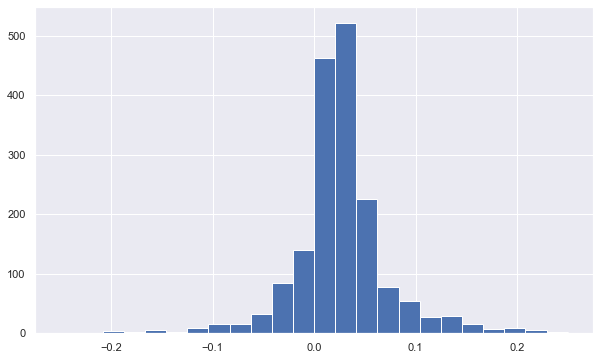

In [11]:
df = cells[(cells["response_classification"] == 1) & (cells.ranksum_p_by_direction < 0.05)]
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.hist(df.mean_right_response - df.mean_left_response, bins=np.linspace(-0.25, 0.25, 25))

In [317]:
df_cre_info.to_csv("/Users/chase/Desktop/cre_info.csv")

In [5]:
df_cre_info.sum()

cre_full              Emx1-IRES-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)S...
cre_abbreviation      Emx1; Ai93Slc17a7; Ai93Slc17a7; Ai94Cux2; Ai93...
num_sessions                                                        818
num_cells_total                                                   43316
num_mice_total                                                      205
num_cells_analyzed                                                32442
dtype: object

In [4]:
miura_sig = ((cells["wilcoxon_signed_rank_p"] < 5e-2) | (cells["ranksum_p_by_direction"] < 5e-2))
miura_sig.sum(), miura_sig.mean() * 100

(20629, 63.58732507243696)

In [5]:
cells.cre_line

specimen_id
589170196    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)
517424547    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)
589170394    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)
589170745    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)
589170856    Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)
                                 ...                     
688140126      Pvalb-IRES-Cre; Ai162(TIT2L-GC6s-ICL-tTA2)
688140466      Pvalb-IRES-Cre; Ai162(TIT2L-GC6s-ICL-tTA2)
688140506      Pvalb-IRES-Cre; Ai162(TIT2L-GC6s-ICL-tTA2)
688140597      Pvalb-IRES-Cre; Ai162(TIT2L-GC6s-ICL-tTA2)
688140401      Pvalb-IRES-Cre; Ai162(TIT2L-GC6s-ICL-tTA2)
Name: cre_line, Length: 32442, dtype: object

In [6]:
cells.cre_line.unique()

array(['Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)',
       'Sst-IRES-Cre; Ai148(TIT2L-GC6f-ICL-tTA2)',
       'Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)',
       'Emx1-IRES-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)',
       'Fezf2-CreER; Ai148(TIT2L-GC6f-ICL-tTA2)',
       'Slc17a7-IRES2-Cre; Camk2a-tTA; Ai94(TITL-GCaMP6s)',
       'Rbp4-Cre_KL100; Camk2a-tTA; Ai93(TITL-GCaMP6f)',
       'Rorb-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)',
       'Slc17a7-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)',
       'Pvalb-IRES-Cre; Ai162(TIT2L-GC6s-ICL-tTA2)',
       'Vip-IRES-Cre; Ai148(TIT2L-GC6f-ICL-tTA2)',
       'Ntsr1-Cre_GN220; Ai148(TIT2L-GC6f-ICL-tTA2)',
       'Tlx3-Cre_PL56; Ai148(TIT2L-GC6f-ICL-tTA2)',
       'Scnn1a-Tg3-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)'], dtype=object)

In [8]:
cells[cells.targeted_structure == "VISp"].groupby(CRE_PLOT_KEY)["depth"].value_counts()

cre_abbrev     depth
Cux2; Ai93     175.0     884
               275.0     620
Emx1; Ai93     375.0     397
               275.0     249
Fezf2; Ai148   400.0     194
               390.0     109
               375.0      96
Nr5a1; Ai93    350.0     200
Ntsr1; Ai148   550.0     539
Pvalb; Ai162   275.0     119
               175.0      49
               375.0      46
               225.0      28
               185.0      14
               200.0      11
Rbp4; Ai93     375.0     286
Rorb; Ai93     275.0     849
Scnn1a; Ai93   350.0     585
               275.0     227
               335.0     123
Slc17a7; Ai93  275.0    1461
               375.0    1159
               175.0    1051
Slc17a7; Ai94  205.0     413
               175.0     404
Sst; Ai148     275.0      85
               375.0      48
               350.0      29
               285.0      17
Tlx3; Ai148    375.0     611
Vip; Ai148     275.0     104
               175.0      56
Name: depth, dtype: int64

In [11]:
# print(cells[cells.targeted_structure == "VISp"].groupby("depth")["is_sr"].value_counts())
depths = []
rates = []
counts = []

for depth in cells[cells.targeted_structure == "VISp"]["depth"].unique():
    df = cells[(cells.targeted_structure == "VISp") & (cells.depth == depth)]
    n = len(df)
    n_sr = np.count_nonzero(df.is_sr)
    depths.append(depth)
    rates.append(n_sr/n)
    counts.append(n)

fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
ax.bar(depths, rates, color="blue")

AttributeError: 'DataFrame' object has no attribute 'is_sr'

Text(0.5, 1.0, 'V1 neurons')

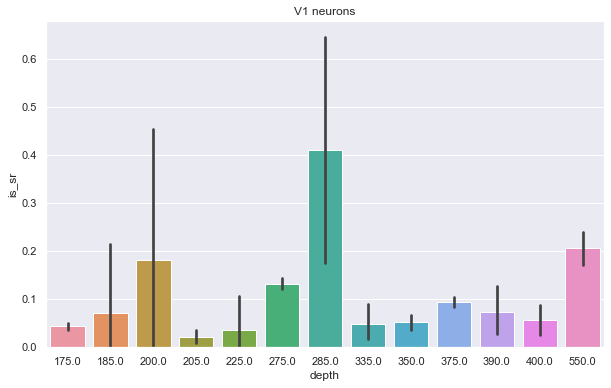

In [291]:
fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
sns.barplot(data=cells[cells.targeted_structure == "VISp"], x="depth", y="is_sr", ax=ax)
ax.set_title("V1 neurons")

In [29]:
cells["depth_trunc"] = 100 * (cells["depth"]/100).astype(int)
cells.at[cells["cre_line"] == "Scnn1a-Tg3-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)", "depth_trunc"] = 200
cells.at[cells["cre_line"] == "Nr5a1-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)", "depth_trunc"] = 200
cells.at[cells["cre_line"] == "Fezf2-CreER; Ai148(TIT2L-GC6f-ICL-tTA2)", "depth_trunc"] = 300
cells.at[cells["depth_trunc"] == 400, "depth_trunc"] = 300

depth_to_layer = {
    100: "2/3",
    200: "4",
    300: "5",
    500: "6",
}

cells["cortical_layer"] = cells["depth_trunc"].apply(lambda depth_trunc: depth_to_layer[depth_trunc])

In [30]:
miura_thresh = 5e-2 # 0.05
dir_thresh = 0.05

response_classification = cells["response_classification"]
cells["is_sr"] = (response_classification.abs() == 1)
is_ds = (cells["ranksum_p_by_direction"] < dir_thresh)
is_sr_ds = (cells["is_sr"]) & is_ds
cells["is_sr_ds"] = is_sr_ds
cells["is_sr_miura"] = ((cells["wilcoxon_signed_rank_p"] < miura_thresh) | (cells["ranksum_p_by_direction"] < miura_thresh))
cells["is_sr_ds_miura"] = cells["is_sr_miura"] & is_ds


# Compute preferred direction
larger_R_response = cells["mean_right_response"] > cells["mean_left_response"]
cells["preferred_direction"] = 0

# pref_dir_temporal = (
#     ((cells["response_classification"] == 1) & larger_R_response)
#      | ((cells["response_classification"] == -1) & ~larger_R_response)
# )

# pref_dir_nasal = (
#     ((cells["response_classification"] == 1) & ~larger_R_response)
#      | ((cells["response_classification"] == -1) & larger_R_response)
# )

# ONLY CONSIDER ENHANCED RESPONSES
pref_dir_temporal = (cells["response_classification"] == 1) & larger_R_response
pref_dir_nasal = (cells["response_classification"] == 1) & ~larger_R_response

cells.loc[is_sr_ds & pref_dir_temporal, "preferred_direction"] = 1
cells.loc[is_sr_ds & pref_dir_nasal, "preferred_direction"] = -1

cells.loc[cells["is_sr_miura"] & is_ds & pref_dir_temporal, "preferred_direction_miura"] = 1
cells.loc[cells["is_sr_miura"] & is_ds & pref_dir_nasal, "preferred_direction_miura"] = -1

cells.head()

,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,...,ranksum_p_by_direction,session_indices_str,depth_trunc,cortical_layer,is_sr,is_sr_ds,is_sr_miura,is_sr_ds_miura,preferred_direction,preferred_direction_miura
specimen_id,,,,,,,,,,,,,,,,,,,,,
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,...,0.311603,"((510174759, 11), (510345479, 67), (510514474,...",100,2/3,False,False,False,False,0,NaN
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,...,0.472405,"((510174759, 109), (510345479, 68), (510514474...",100,2/3,False,False,False,False,0,NaN
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,...,0.018225,"((510174759, 27), (510345479, 205), (510514474...",100,2/3,False,False,True,True,0,NaN
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,...,0.713904,"((510174759, 6), (510345479, 206), (510514474,...",100,2/3,False,False,False,False,0,NaN
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,...,0.012153,"((510174759, 9), (510345479, 22), (510514474, 9))",100,2/3,False,False,True,True,0,NaN


In [31]:
n_sr = cells["is_sr"].sum()
n_sr_e = (cells["response_classification"] == 1).sum()
n_sr_s = (cells["response_classification"] == -1).sum()
n_sr_ds_T = ((cells["response_classification"] == 1) & (cells["preferred_direction"] == 1)).sum()
n_sr_ds_N = ((cells["response_classification"] == 1) & (cells["preferred_direction"] == -1)).sum()
n_sr_not_ds = ((cells["response_classification"] == 1) & (cells["preferred_direction"] == 0)).sum()
print(f"{n_sr:,} out of {len(cells):,} ({n_sr/len(cells)*100:.1f}%) cells were saccade-responsive, with {n_sr_e:,} ({n_sr_e/n_sr*100:.1f}%) having an enhanced response and {n_sr_s:,} ({n_sr_s/n_sr*100:.1f}%) having a suppressed response.")
print(f"out of {n_sr_e:,} saccade-responsive cells with an enhanced response, {n_sr_ds_T:,} ({n_sr_ds_T/n_sr_e*100:.1f}%) preferred temporal saccades, {n_sr_ds_N:,} ({n_sr_ds_N/n_sr_e*100:.1f}%) preferred nasal saccades, and {n_sr_not_ds:,} ({n_sr_not_ds/n_sr_e*100:.1f}%) were not direction-selective.")

3,071 out of 32,442 (9.5%) cells were saccade-responsive, with 2,696 (87.8%) having an enhanced response and 375 (12.2%) having a suppressed response.
out of 2,696 saccade-responsive cells with an enhanced response, 1,467 (54.4%) preferred temporal saccades, 318 (11.8%) preferred nasal saccades, and 911 (33.8%) were not direction-selective.


([<matplotlib.patches.Wedge at 0x7fc2c9f350d0>,
 [Text(1.0517159418503321, 0.3223252668623246, 'SR'),
  Text(-1.0517159343057645, -0.3223252914795128, 'Not SR')],
 [Text(0.573663241009272, 0.1758137819249043, '9.5%'),
  Text(-0.5736632368940533, -0.1758137953524615, '90.5%')])

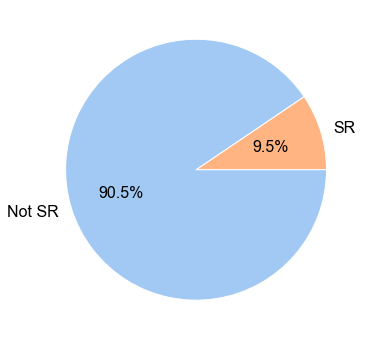

In [32]:
pie_data = [
    (cells["is_sr"]).sum(),
    (~cells["is_sr"]).sum(),
]
pie_labels = ["SR", "Not SR"]
plt.figure(figsize=(6, 6), facecolor="white")
colors = reversed(sns.color_palette("pastel")[:len(pie_data)]) # Reversed so it matches coloring below lol
plt.pie(pie_data, labels=pie_labels, colors=colors, autopct="%.1f%%", textprops=dict(fontsize=16, color="black"))

In [16]:
label_none = "No response"
label_enhanced = "Enhanced: No DS"
label_suppressed = "Suppressed"
label_nasal = "Enhanced: Nasal"
label_temporal = "Enhanced: Temporal"

cells["sr_label"] = label_none
cells.loc[(cells["response_classification"] == 1) & ~(cells["is_sr_ds"]), "sr_label"] = label_enhanced
cells.loc[(cells["response_classification"] == -1), "sr_label"] = label_suppressed
cells.loc[(cells["is_sr"]) & (cells["preferred_direction"] == -1), "sr_label"] = label_nasal
cells.loc[(cells["is_sr"]) & (cells["preferred_direction"] == 1), "sr_label"] = label_temporal

cells["sr_label_miura"] = label_none
cells.loc[(cells["is_sr_miura"]) & ~(cells["is_sr_ds_miura"]), "sr_label_miura"] = "SR"
cells.loc[(cells["is_sr_miura"]) & (cells["preferred_direction_miura"] == -1), "sr_label_miura"] = label_nasal
cells.loc[(cells["is_sr_miura"]) & (cells["preferred_direction_miura"] == 1), "sr_label_miura"] = label_temporal

print(cells["sr_label"].value_counts())
print()
print(cells["sr_label_miura"].value_counts())

SR_LABELS = [
    (label_none, "gray"),
    (label_suppressed, "purple"),
    (label_enhanced, "green"),
    (label_nasal, "b"),
    (label_temporal, "r"),
]

No response           29371
Enhanced: Temporal     1467
Enhanced: No DS         911
Suppressed              375
Enhanced: Nasal         318
Name: sr_label, dtype: int64

No response           24961
SR                     5696
Enhanced: Temporal     1467
Enhanced: Nasal         318
Name: sr_label_miura, dtype: int64


In [33]:
metrics = load_additional_data("metrics.csv")
metrics.drop([c for c in metrics.columns if "Unnamed" in c], axis=1, inplace=True)

dsi_df = load_additional_data("dsi.csv")
metrics = metrics.merge(dsi_df[["cell_specimen_id", "DSI_pref_tf"]], on="cell_specimen_id")
metrics.set_index("cell_specimen_id", inplace=True)
# metrics.head()

cells_and_metrics = cells.join(metrics, how="inner")
print(f"{len(cells_and_metrics):,}/{len(cells):,} cells have associated metrics")

cells_and_metrics.head()

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3361: DtypeWarning: Columns (4,8,12,16,20,32,53,69) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


21,612/32,442 cells have associated metrics


,cre_line,cre_abbrev,depth,targeted_structure,container_id,session_indices,response_classification,p_value,n_left,n_right,...,run_stat_dg,responsive_rundg,run_corr_mean,run_corr_A_lw,run_corr_B_lw,run_corr_C_lw,responsive_run,dg_all_RidgeRegress_CC,cluster_id,DSI_pref_tf
589170196,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 11), (510345479, 67), (510514474,...",0.0,0.148500,25.0,36.0,...,NaN,False,0.042226,0.071127,0.042226,0.030272,True,0.060153,12.0,0.527993
517424547,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 109), (510345479, 68), (510514474...",0.0,0.849025,25.0,36.0,...,NaN,False,0.055001,-0.002882,0.055001,0.023352,True,0.190018,14.0,1.000000
589170394,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 27), (510345479, 205), (510514474...",0.0,0.994925,25.0,36.0,...,NaN,False,0.010461,-0.016332,0.010461,0.007804,True,0.007472,8.0,0.878755
589170745,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 6), (510345479, 206), (510514474,...",0.0,0.018600,25.0,36.0,...,NaN,False,-0.018242,0.014539,-0.018242,0.025295,True,0.138445,12.0,0.796653
589170856,Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f),Cux2;Ai93,175.0,VISp,511510718.0,"((510174759, 9), (510345479, 22), (510514474, 9))",0.0,0.231125,25.0,36.0,...,NaN,False,0.159348,-0.005516,0.159348,-0.014270,True,0.238036,8.0,0.639498


# Fraction of responsive cells in session vs saccade frequency

In [228]:
mean_sacc_freq = []
frac_sr = []
cre = []

for data in load_data():
    start, end = data["start_end"]
    n_sacc = len(data["saccades"])
    c = str(match_cre_line(data))
    freq = n_sacc / ((end-start)/FRAME_RATE)
    cell_ids = data["cell_specimen_ids"]
    n_sr = int(cells["is_sr"][cells.index.isin(cell_ids)].sum())
    frac = n_sr / len(cell_ids)

    mean_sacc_freq.append(freq)
    frac_sr.append(frac)
    cre.append(c)

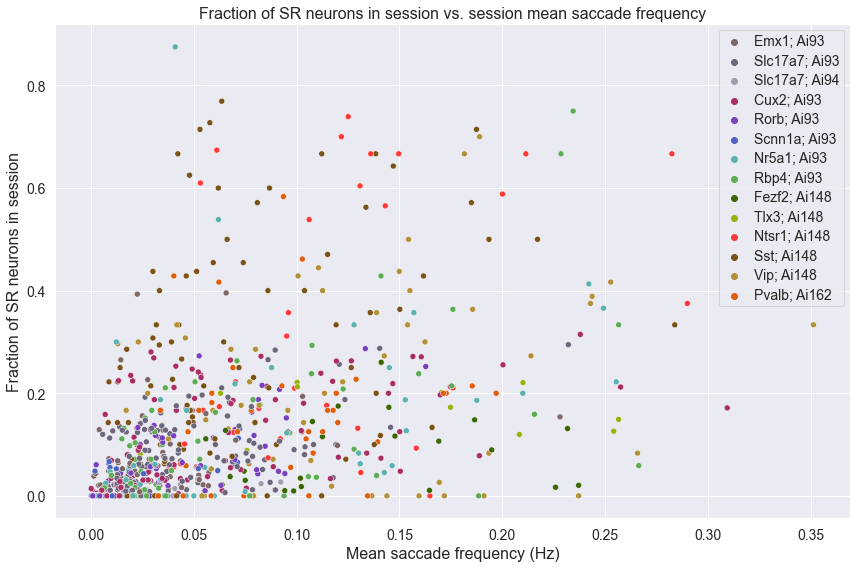

In [229]:
fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

sns.scatterplot(x=mean_sacc_freq, y=frac_sr, ax=ax, hue=cre, palette=CRE_COLORS, hue_order=CRE_ORDERING)
# plt.setp(ax.get_legend().get_title(), text="Cre", fontsize=14)
plt.setp(ax.get_legend().get_texts(), fontsize=14)
plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
ax.set_xlabel("Mean saccade frequency (Hz)", fontsize=16)
ax.set_ylabel("Fraction of SR neurons in session", fontsize=16)
ax.set_title("Fraction of SR neurons in session vs. session mean saccade frequency", fontsize=16)
fig.tight_layout()
savefig(fig, "frac_sr_neurons_vs_mean_sacc_freq.png")

# Sort based on peak times

In [230]:
window_radius = 30 # 1 sec
trace_len = 2*window_radius+1
cell_mean_traces = []
cell_mean_traces_train = []
cell_mean_traces_test = []
cell_ds = []

np.random.seed(1)

for specimen_id, row in tqdm(cells[cells["is_sr"]].iterrows(), total=int(cells["is_sr"].sum())):
    ds = None
    if row["preferred_direction"] == -1:
        ds = "L"
    elif row["preferred_direction"] == 1:
        ds = "R"
    
    # Compute all in all sessions
    traces = []
    
    for sid, cell_index in row["session_indices"]:
        data = load_data_by_session_id(sid)

        for ss, se in data["saccades"]:
            mag, dir = get_saccade_magnitude_direction(data["eye_tracking"], ss, se)
            
            if ds is None or dir == ds: # Filter by direction selectivity
                times = slice(ss-window_radius, ss+window_radius+1)
                trace = data["dff_traces"][cell_index, times]
                if len(trace) == trace_len:
                    traces.append(trace)

    random_idx = np.random.permutation(len(traces))
    mid = len(traces)//2
    train_idx, test_idx = random_idx[:mid], random_idx[mid:]

    traces = np.array(traces)
    cell_mean_traces.append(np.mean(traces, axis=0))
    cell_mean_traces_train.append(np.mean(traces[train_idx], axis=0))
    cell_mean_traces_test.append(np.mean(traces[test_idx], axis=0))
    cell_ds.append(ds)

cell_mean_traces = np.array(cell_mean_traces)
cell_mean_traces_train = np.array(cell_mean_traces_train)
cell_mean_traces_test = np.array(cell_mean_traces_test)

  0%|          | 0/3071 [00:00<?, ?it/s]

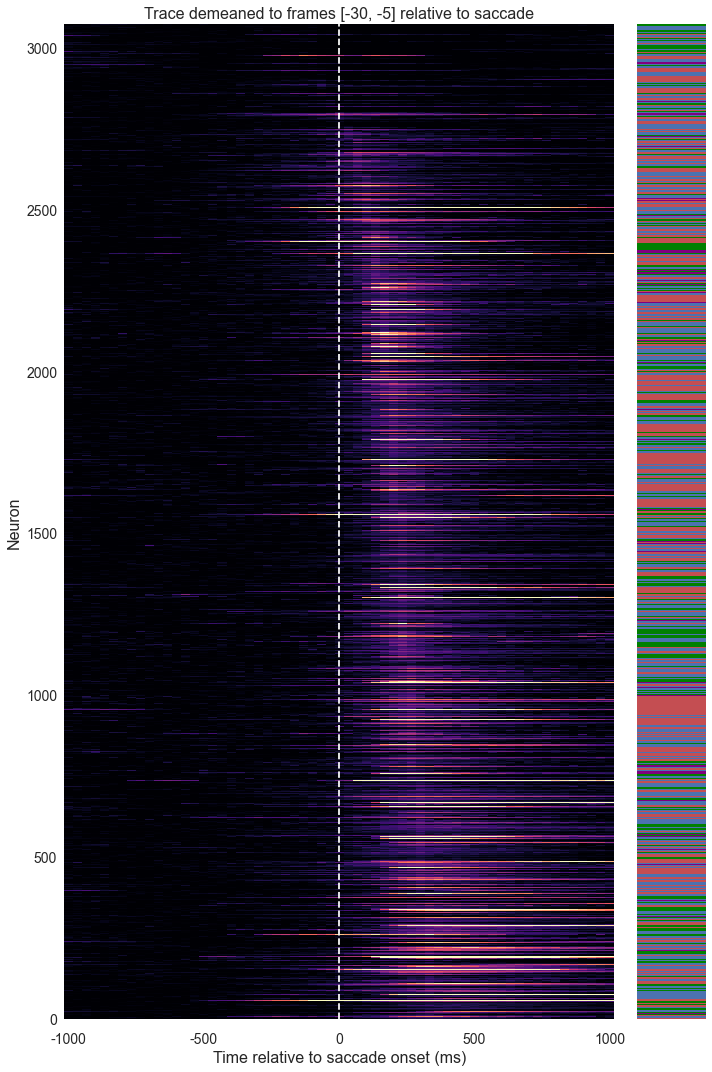

In [231]:
with plt.style.context("seaborn"):
    a = cell_mean_traces - cell_mean_traces[:, window_radius-30:window_radius-5].mean(axis=1, keepdims=True)
    peak_dff_window = slice(window_radius-3, window_radius+11) # 3 frames before onset to 10 frames after
    peak_dff_frame = np.argmax(a[:, peak_dff_window], axis=1)
    sort_idx = np.argsort(-peak_dff_frame)

    fig, (ax_traces, ax_labels) = plt.subplots(ncols=2, figsize=(10, 15), facecolor="white", gridspec_kw={'width_ratios': [8, 1]})
    cax = ax_traces.pcolormesh(a[sort_idx], cmap="magma", vmin=0, vmax=np.percentile(a, 99))
    # cb = fig.colorbar(cax, pad=0.015, label="dF/F")
    set_major_minor_ticks(ax_traces, window_radius, center=window_radius+0.5) # 0.5 center so it aligns at the center of the color cell
    ax_traces.axvline(window_radius+0.5, color="white", linestyle="dashed")
    ax_traces.set_ylabel("Neuron", fontsize=16)
    ax_traces.set_xlabel("Time relative to saccade onset (ms)", fontsize=16)
    plt.setp((ax_traces.get_xticklabels(), ax_traces.get_yticklabels()), fontsize=14)
    ax_traces.set_title("Trace demeaned to frames [-30, -5] relative to saccade", fontsize=16)


    # Plot labels
    label_to_color = []
    colors = []
    for l, c in SR_LABELS:
        if l is not label_none:
            label_to_color.append(l)
            colors.append(c)
    labels = []
    for specimen_id, row in cells[cells["is_sr"]].iterrows():
        labels.append(label_to_color.index(row["sr_label"]))
    cmap = matplotlib.colors.ListedColormap(colors)
    labels = np.array(labels).reshape((len(labels), 1))
    # labels = np.ones((len(labels), 200)) * labels
    ax_labels.imshow(labels, cmap=cmap)
    ax_labels.set_aspect("auto")
    ax_labels.grid(False)
    ax_labels.xaxis.set_visible(False)
    ax_labels.yaxis.set_visible(False)
    fig.tight_layout()

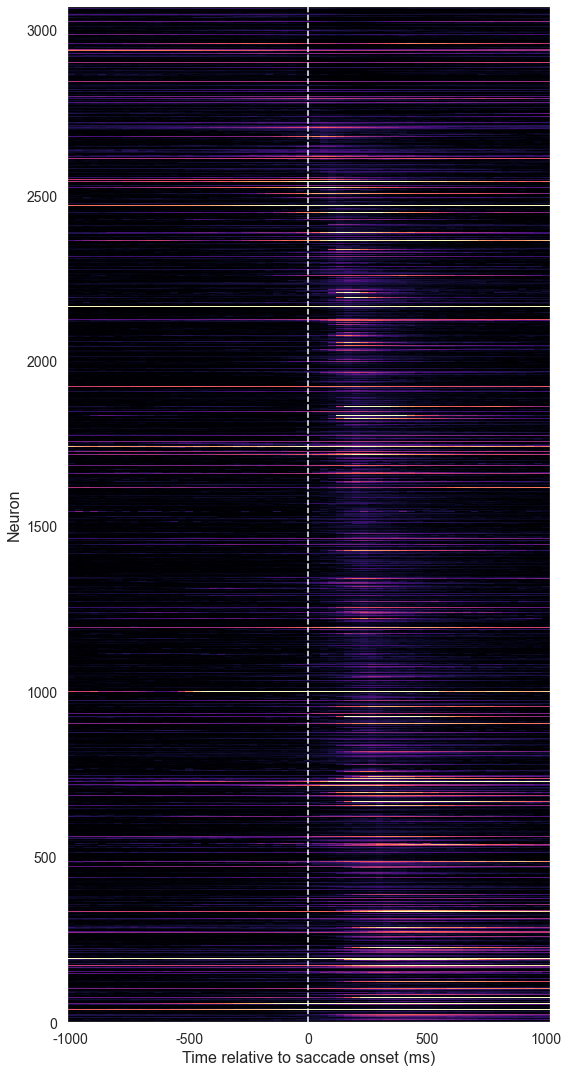

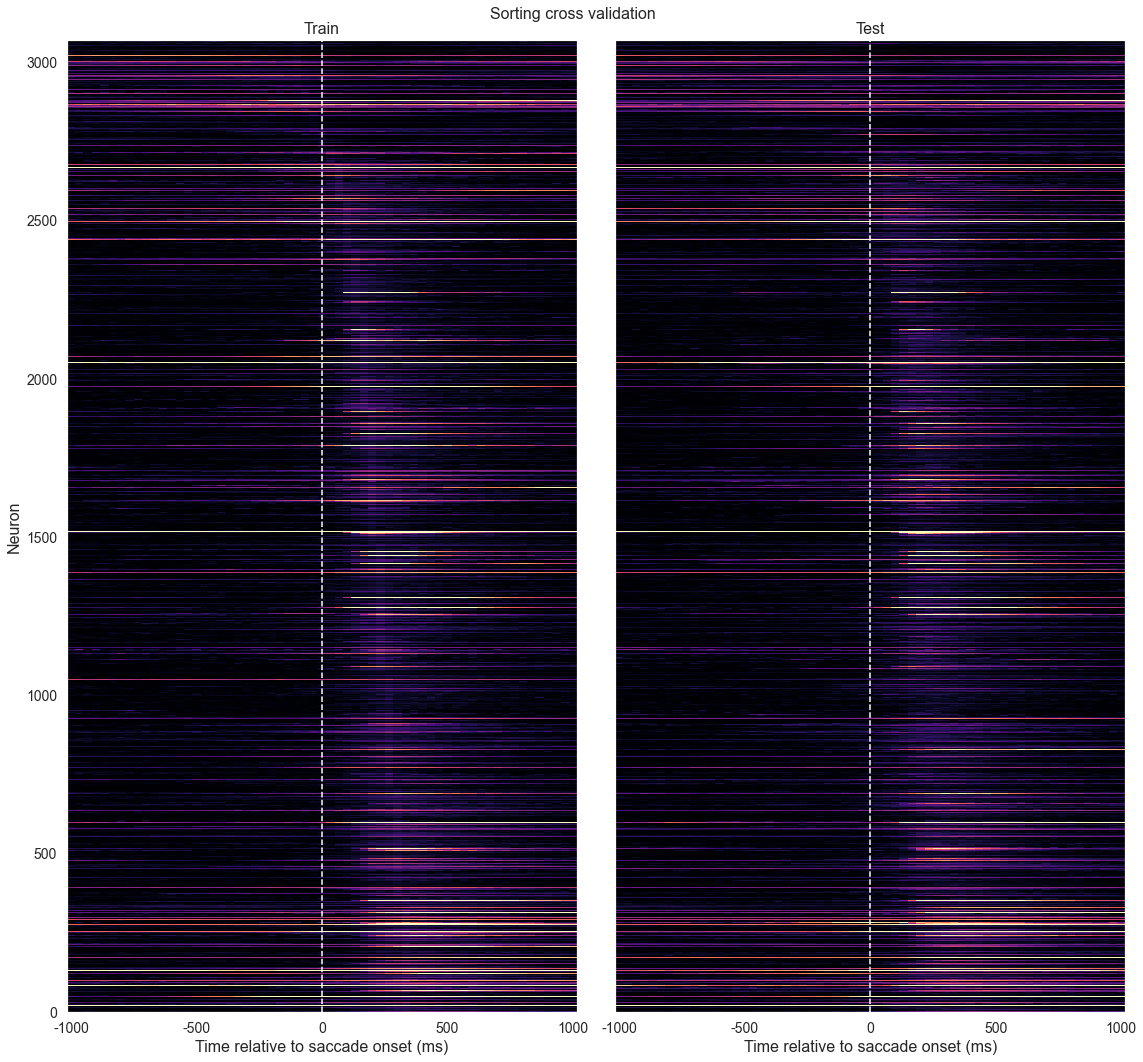

In [33]:
peak_dff_window = slice(window_radius-3, window_radius+11) # 3 frames before onset to 10 frames after
peak_dff_frame = np.argmax(cell_mean_traces[:, peak_dff_window], axis=1)
mask = cells.index[cells["is_sr"]].isin(cells_and_metrics.index)
cells_and_metrics.loc[cells_and_metrics.index[cells_and_metrics["is_sr"]], "peak_dff_frame"] = peak_dff_frame[mask]
sort_idx = np.argsort(-peak_dff_frame)
# sort_idx = sort_idx[:200]

fig, ax = plt.subplots(figsize=(8, 15), facecolor="white")
sorted_traces = cell_mean_traces[sort_idx]
vmin = 0 # np.percentile(sorted_traces, 1)
vmax = np.percentile(sorted_traces, 99)
cax = ax.pcolormesh(sorted_traces, cmap="magma", vmin=vmin, vmax=vmax)
# cb = fig.colorbar(cax, pad=0.015, label="dF/F")
set_major_minor_ticks(ax, window_radius, center=window_radius+0.5) # 0.5 center so it aligns at the center of the color cell
ax.axvline(window_radius+0.5, color="white", linestyle="dashed")
ax.set_ylabel("Neuron", fontsize=16)
ax.set_xlabel("Time relative to saccade onset (ms)", fontsize=16)
plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)
fig.tight_layout()

# Validation
fig, axs = plt.subplots(ncols=2, figsize=(16, 15), facecolor="white")
peak_dff_frame = np.argmax(cell_mean_traces_train[:, peak_dff_window], axis=1)
sort_idx = np.argsort(-peak_dff_frame)

axs[0].pcolormesh(cell_mean_traces_train[sort_idx], cmap="magma", vmin=0, vmax=np.percentile(cell_mean_traces_train, 99))
axs[0].set_title("Train", fontsize=16)
axs[1].pcolormesh(cell_mean_traces_test[sort_idx], cmap="magma", vmin=0, vmax=np.percentile(cell_mean_traces_test, 99))
axs[1].set_title("Test", fontsize=16)

for i, ax in enumerate(axs):
    set_major_minor_ticks(ax, window_radius, center=window_radius+0.5) # 0.5 center so it aligns at the center of the color cell
    ax.axvline(window_radius+0.5, color="white", linestyle="dashed")
    if i == 0:
        ax.set_ylabel("Neuron", fontsize=16)
    else:
        ax.yaxis.set_visible(False)
    ax.set_xlabel("Time relative to saccade onset (ms)", fontsize=16)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=14)

fig.suptitle("Sorting cross validation", fontsize=16)
fig.tight_layout()

# Visualize how many cells respond

In [34]:
df_rows = []

for cre_line in CRE_ORDERING:
    for targeted_structure in AREA_ORDERING:
        df = cells[(cells[CRE_PLOT_KEY] == cre_line) & (cells["targeted_structure"] == targeted_structure)]
        n_cells = len(df)

        if n_cells > 0:
            df_responsive = df[df["is_sr"]]
            n_responsive = len(df_responsive)

            df_responsive_miura = df[df["is_sr_miura"]]
            n_responsive_miura = len(df_responsive_miura)

            df_rows.append({
                CRE_PLOT_KEY: cre_line,
                "targeted_structure": targeted_structure,
                "n_cells": n_cells,
                "n_cells_responsive": n_responsive,
                "frac_responsive": n_responsive/n_cells,
                "n_cells_responsive_miura": n_responsive_miura,
                "frac_responsive_miura": n_responsive_miura/n_cells,
            })

responses_by_cre_and_area = pd.DataFrame(df_rows)
responses_by_cre_and_area.head()

,cre_abbrev,targeted_structure,n_cells,n_cells_responsive,frac_responsive,n_cells_responsive_miura,frac_responsive_miura
0,Emx1;Ai93,VISp,646,20,0.030960,266,0.411765
1,Emx1;Ai93,VISl,886,97,0.109481,633,0.714447
2,Emx1;Ai93,VISal,772,61,0.079016,543,0.703368
3,Emx1;Ai93,VISpm,274,13,0.047445,111,0.405109
4,Emx1;Ai93,VISam,363,80,0.220386,209,0.575758


In [35]:
df = responses_by_cre_and_area.pivot(CRE_PLOT_KEY, "targeted_structure", "n_cells")
df = df.reindex(CRE_ORDERING, axis=0).reindex(AREA_ORDERING, axis=1)#.reindex(columns=[AREA_ABBREV[a] for a in AREA_ORDERING])
df.columns = [AREA_ABBREV[a] for a in df.columns]
df.head()

,V1,LM,AL,PM,AM,RL
cre_abbrev,,,,,,
Emx1;Ai93,646.0,886.0,772.0,274.0,363.0,2079.0
Slc17a7;Ai93,3671.0,2033.0,338.0,1293.0,235.0,137.0
Slc17a7;Ai94,817.0,NaN,NaN,NaN,NaN,NaN
Cux2;Ai93,1504.0,1311.0,1046.0,1038.0,916.0,1017.0
Rorb;Ai93,849.0,683.0,299.0,292.0,385.0,977.0


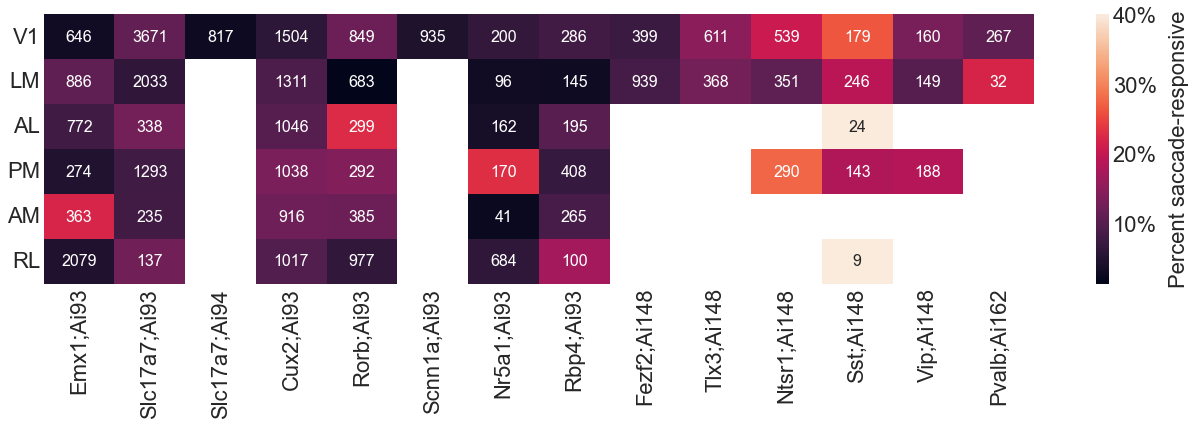

In [39]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(18, 6), facecolor="w")
    x, xorder = CRE_PLOT_KEY, CRE_ORDERING
    y, yorder, ylabels = "targeted_structure", AREA_ORDERING, [AREA_ABBREV[a] for a in AREA_ORDERING]
    frac_responsive = responses_by_cre_and_area.pivot(y, x, "frac_responsive")
    n_cells = responses_by_cre_and_area.pivot(y, x, "n_cells")

    frac_responsive = frac_responsive.reindex(yorder, axis=0).reindex(xorder, axis=1)
    n_cells = n_cells.reindex(yorder, axis=0).reindex(xorder, axis=1)

    # sns.heatmap(frac_responsive, annot=n_cells, fmt=".0f", cmap="magma", ax=axs[0], vmin=0, vmax=1)
    # sns.heatmap(frac_responsive_miura, annot=n_cells, fmt=".0f", cmap="magma", ax=axs[1], vmin=0, vmax=1)
    sns.heatmap(frac_responsive, annot=n_cells, fmt=".0f", ax=ax, annot_kws=dict(fontsize=16), vmax=0.4)
    # sns.heatmap(frac_responsive_miura, annot=n_cells, fmt=".0f", ax=axs[1], annot_kws=dict(fontsize=16))
    plt.setp(ax, xlabel="", ylabel="")
    plt.setp(ax.get_xticklabels(), fontsize=22, rotation=90)
    ax.set_yticklabels(ylabels, fontsize=22, rotation=0)
    # ax.set_yticklabels(CRE_LINE_REPORTER_ORDERING, fontsize=18, rotation=0)
    # ax.set_title("Fraction of SR cells by cre and region (n = total no. imaged cells)", fontsize=22)

    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize=22)
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels([f"{tick*100:.0f}%" for tick in cbar.get_ticks()])
    cbar.set_label("Percent saccade-responsive", fontsize=22, labelpad=12, va="top") # , rotation=270, va="bottom"

    # axs[1].set_title("Significance method: Miura", fontsize=18)
    fig.tight_layout()
    savefig(fig, "fraction_responsive_heatmap.png") 

cre_abbrev     is_sr
Cux2; Ai93     False    6169
               True      663
Emx1; Ai93     False    4654
               True      366
Fezf2; Ai148   False    1230
               True      108
Nr5a1; Ai93    False    1249
               True      104
Ntsr1; Ai148   False     951
               True      229
Pvalb; Ai162   False     263
               True       36
Rbp4; Ai93     False    1284
               True      115
Rorb; Ai93     False    3157
               True      328
Scnn1a; Ai93   False     894
               True       41
Slc17a7; Ai93  False    6992
               True      715
Slc17a7; Ai94  False     796
               True       21
Sst; Ai148     False     466
               True      135
Tlx3; Ai148    False     840
               True      139
Vip; Ai148     False     426
Name: is_sr, dtype: int64


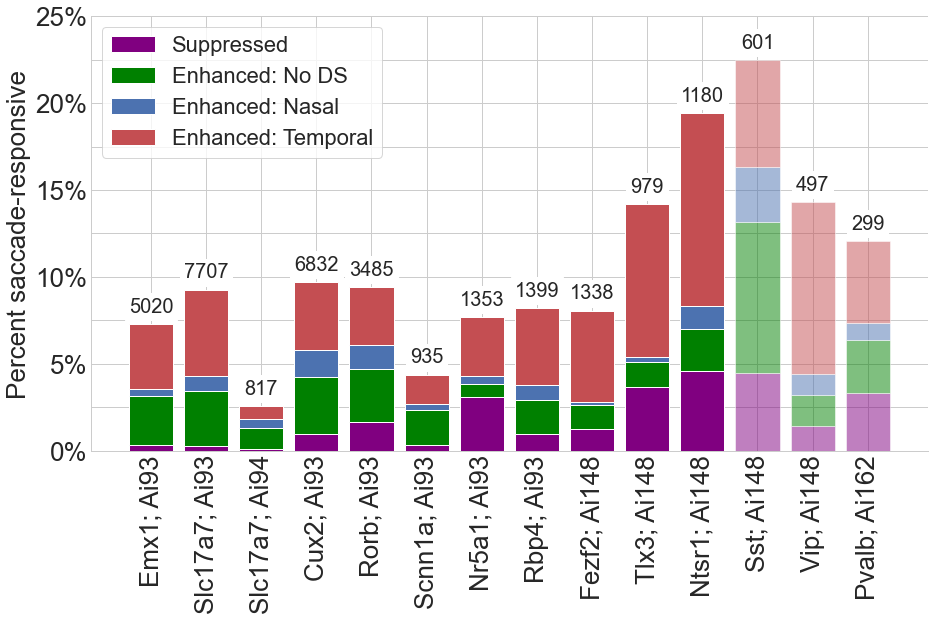

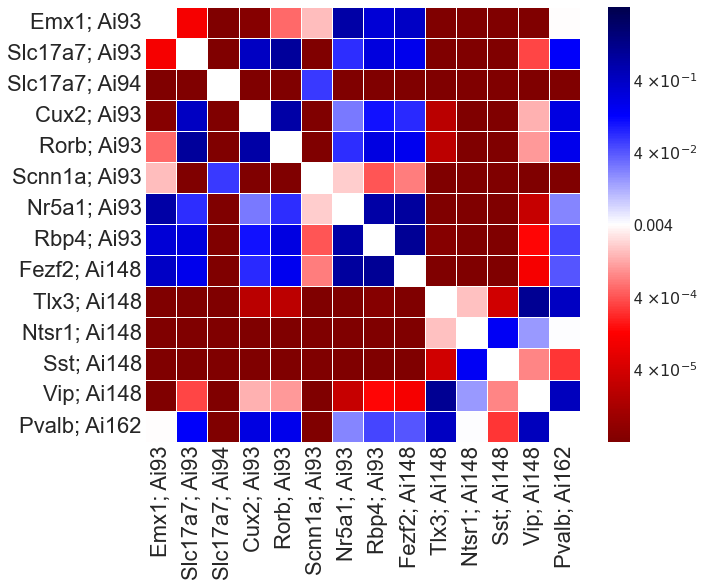

In [247]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(15, 8), facecolor="white")
    bottom = None
    df = cells["sr_label"].groupby(cells[CRE_PLOT_KEY]).value_counts(normalize=True)

    for sr_label, color in SR_LABELS:
        if sr_label == "No response": continue
        heights = []
        excitatory = []
        for cre in CRE_ORDERING:
            heights.append(df[cre][sr_label] if sr_label in df[cre] else 0)
            cre_line = match_cre_line(cre)
            excitatory.append(cre_line.is_excitatory)

        bar_container = ax.bar(CRE_ORDERING, heights, bottom=bottom, label=sr_label, color=color)

        for patch, is_excitatory in zip(bar_container.patches, excitatory):
            if not is_excitatory:
                # patch.set_hatch("ooo")
                patch.set_alpha(0.5)

        bottom = heights if bottom is None else bottom + np.array(heights)

    ax.legend(fontsize=22, frameon=True, loc="upper left")
    plt.setp(ax.get_xticklabels(), fontsize=26, rotation=90)
    ax.set_xlabel("")
    ax.set_ylim(0, 0.2)
    yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25]
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick}%" if int(tick) == tick else None for tick in yticks], fontsize=26)
    ax.set_ylabel("Percent saccade-responsive", fontsize=26)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # for text, cre in zip(ax.get_xticklabels(), CRE_ORDERING):
    #     text.set_bbox(dict(facecolor=match_cre_line(cre).color, alpha=0.5))

    bar_labels = [np.sum(cells[CRE_PLOT_KEY] == cre) for cre in CRE_ORDERING]
    ax.bar_label(ax.containers[-1], labels=bar_labels, fmt="%d", padding=8, fontsize=20, backgroundcolor="w")
    savefig(fig, "fraction_responsive_by_cre.png")

    # Generate probability matrix
    p_matrix = np.zeros((len(CRE_ORDERING), len(CRE_ORDERING)), dtype=float)
    counts = cells.groupby(CRE_PLOT_KEY)["is_sr"].value_counts()

    print(counts.head(-1))
            
    for i in range(len(CRE_ORDERING)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(CRE_ORDERING)):
            observed = [
                [counts[CRE_ORDERING[i]][True], counts[CRE_ORDERING[i]][False]],
                [counts[CRE_ORDERING[j]][True], counts[CRE_ORDERING[j]][False]]
            ]
            p_val = stats.chi2_contingency(observed)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val

    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=CRE_ORDERING, title=f"", ticklabelfontsize=22, figsize=(10, 8))
    savefig(fig, "sr_by_cre_proba.png")

targeted_structure  is_sr
VISal               False    2523
                    True      313
VISam               False    1923
                    True      282
Name: is_sr, dtype: int64


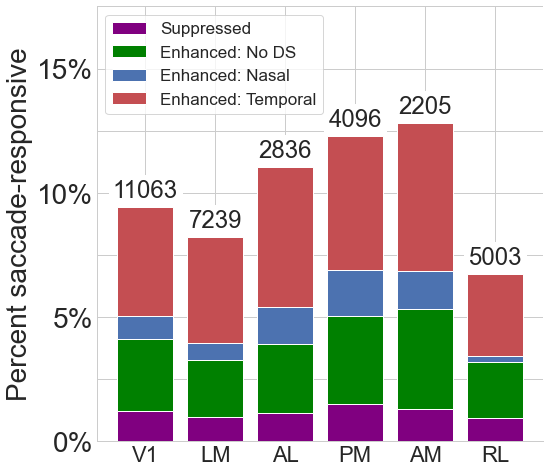

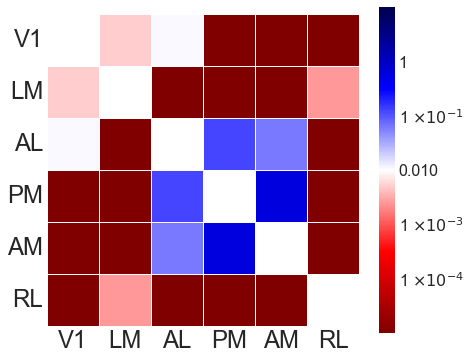

In [237]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 8), facecolor="white")
    bottom = None
    df = cells["sr_label"].groupby(cells["targeted_structure"]).value_counts(normalize=True)
    areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

    for sr_label, color in SR_LABELS:
        if sr_label == "No response": continue
        heights = []
        for area in AREA_ORDERING:
            heights.append(df[area][sr_label] if sr_label in df[area] else 0)
        ax.bar(areas, heights, bottom=bottom, label=sr_label, color=color)
        heights = np.array(heights)
        bottom = heights if bottom is None else bottom + heights

    # ax.bar(agg_tips.index, agg_tips['Female'], bottom=agg_tips['Male'],
    # label='Female')
    # ax.set_title('Tips by Day and Gender')
    ax.legend(fontsize=17, frameon=True, loc="upper left")
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=22)
    ax.set_xlabel("")
    yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick}%" if int(tick) == tick else None for tick in yticks], fontsize=28)
    ax.set_ylabel("Percent saccade-responsive", fontsize=28)

    bar_labels = [np.sum(cells["targeted_structure"] == area) for area in AREA_ORDERING]
    ax.bar_label(ax.containers[-1], labels=bar_labels, fmt="{}", padding=5, fontsize=24, backgroundcolor="w")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    savefig(fig, "fraction_responsive_by_area.png")

    # Generate probability matrix
    p_matrix = np.zeros((len(AREA_ORDERING), len(AREA_ORDERING)), dtype=float)
    counts = cells.groupby("targeted_structure")["is_sr"].value_counts()

    print(counts.head(4))
            
    for i in range(len(AREA_ORDERING)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(AREA_ORDERING)):
            observed = [
                [counts[AREA_ORDERING[i]][True], counts[AREA_ORDERING[i]][False]],
                [counts[AREA_ORDERING[j]][True], counts[AREA_ORDERING[j]][False]]
            ]
            p_val = stats.chi2_contingency(observed)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val

    fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=areas, title=f"", figsize=(7, 6), ticklabelfontsize=24, xticklabelrotation=0)
    savefig(fig, "sr_by_area_proba.png")

In [213]:
cells["is_sr"].groupby(cells["targeted_structure"]).value_counts(normalize=False)

targeted_structure  is_sr
VISal               False     2523
                    True       313
VISam               False     1923
                    True       282
VISl                False     6645
                    True       594
VISp                False    10020
                    True      1043
VISpm               False     3593
                    True       503
VISrl               False     4667
                    True       336
Name: is_sr, dtype: int64

# Direction selectivity

SR: -0.01, 0.49, 0.93 (mean = 0.50 ± 1.41)
SR-DS-R: 0.58, 0.84, 1.27 (mean = 1.06 ± 1.56)
SR-DS-L: -1.02, -0.68, -0.39 (mean = -0.88 ± 1.03)


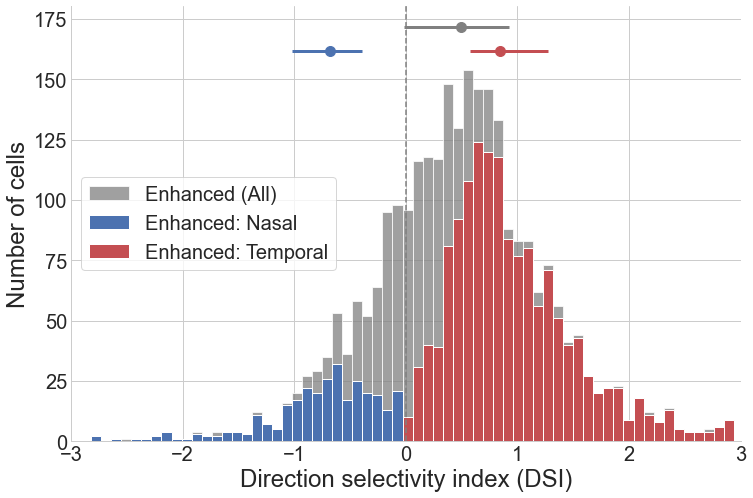

In [238]:
with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

    is_sr = cells["response_classification"] == 1
    values = cells[is_sr]["direction_selectivity"].dropna().values
    # values = cells["direction_selectivity"].dropna().values # all cells
    p25_sr, p50_sr, p75_sr = np.quantile(values, [0.25, 0.5, 0.75])
    print(f"SR: {p25_sr:.2f}, {p50_sr:.2f}, {p75_sr:.2f} (mean = {values.mean():.2f} ± {values.std():.2f})")
    values = values[(-10 < values) & (values < 10)]
    xlim = -3, 3
    n, bins, _ = ax.hist(values, bins=np.arange(*xlim, 0.09), color="gray", alpha=0.75, label="Enhanced (All)")

    ds_inclusion = is_sr & (cells["is_sr_ds"])
    srds_R = cells[ds_inclusion & (cells["preferred_direction"] == 1)]["direction_selectivity"].dropna().values
    srds_L = cells[ds_inclusion & (cells["preferred_direction"] == -1)]["direction_selectivity"].dropna().values
    # srds_R = cells[is_sr & (cells["mean_right_response"].abs() >= 2*cells["mean_left_response"])]["direction_selectivity"].dropna().values
    # srds_L = cells[is_sr & (cells["mean_left_response"].abs() >= 2*cells["mean_right_response"])]["direction_selectivity"].dropna().values
    p25_R, p50_R, p75_R = np.quantile(srds_R, [0.25, 0.5, 0.75])
    p25_L, p50_L, p75_L = np.quantile(srds_L, [0.25, 0.5, 0.75])
    print(f"SR-DS-R: {p25_R:.2f}, {p50_R:.2f}, {p75_R:.2f} (mean = {srds_R.mean():.2f} ± {srds_R.std():.2f})")
    print(f"SR-DS-L: {p25_L:.2f}, {p50_L:.2f}, {p75_L:.2f} (mean = {srds_L.mean():.2f} ± {srds_L.std():.2f})")
    srds_L = srds_L[(-10 < srds_L) & (srds_L < 10)]
    srds_R = srds_R[(-10 < srds_R) & (srds_R < 10)]
    ax.hist(srds_L, bins=bins, alpha=1, color="b", label="Enhanced: Nasal")
    ax.hist(srds_R, bins=bins, alpha=1, color="r", label="Enhanced: Temporal")

    ax.set_xlim(*xlim)
    y = ax.get_ylim()[1]

    ax.scatter(p50_sr, y+10, color="gray", s=100, zorder=10)
    ax.hlines(xmin=p25_sr, xmax=p75_sr, y=y+10, color="gray", linewidth=3, zorder=10)

    ax.scatter(p50_L, y, color="b", s=100, zorder=10)
    ax.hlines(xmin=p25_L, xmax=p75_L, y=y, color="b", linewidth=3, zorder=10)

    ax.scatter(p50_R, y, color="r", s=100, zorder=10)
    ax.hlines(xmin=p25_R, xmax=p75_R, y=y, color="r", linewidth=3, zorder=10)

    ax.axvline(0, color="gray", linestyle="dashed")

    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=20)
    ax.set_xlabel("Direction selectivity index (DSI)", fontsize=24)
    ax.set_ylabel("Number of cells", fontsize=24)
    ax.legend(fontsize=20, loc="center left", frameon=True)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    savefig(fig, "direction_selectivity.png")

    # ax.set_title("Direction selectivity")

mean no pref N/T: 0.0249, 0.0302
mean nasal N/T: 0.0528, 0.0074
mean temporal N/T: 0.0015, 0.0490
n_sr_enhanced: 2696
no_pref: 911
nasal: 318
temporal: 1467


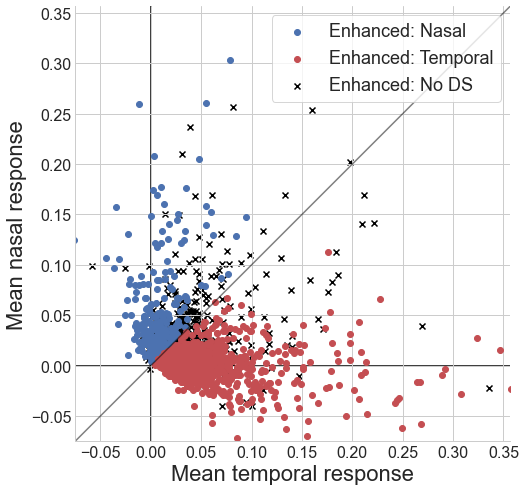

In [239]:
def plot_yeqx(ax, **kwargs):
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, zorder=1, **kwargs)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(8, 8), facecolor="white")
    x = cells["mean_right_response"].values
    y = cells["mean_left_response"].values

    is_sr = cells["response_classification"] == 1
    n_sr = is_sr.sum()
    no_pref = is_sr & ~(cells["is_sr_ds"])
    nasal = is_sr & (cells["preferred_direction"] == -1)
    nasal_suppressed = is_sr & (cells["preferred_direction"] == -1)
    temporal = is_sr & (cells["preferred_direction"] == 1)

    ax.scatter(x[nasal], y[nasal], color="b", alpha=1, label=f"Enhanced: Nasal") # ({nasal.sum()/n_sr*100:.1f}%)
    ax.scatter(x[temporal], y[temporal], color="r", alpha=1, label=f"Enhanced: Temporal") # ({temporal.sum()/n_sr*100:.1f}%)
    ax.scatter(x[no_pref], y[no_pref], color="black", marker="x", label=f"Enhanced: No DS", zorder=0) # ({no_pref.sum()/n_sr*100:.1f}%)

    print(f"mean no pref N/T: {y[no_pref].mean():.4f}, {x[no_pref].mean():.4f}")
    print(f"mean nasal N/T: {y[nasal].mean():.4f}, {x[nasal].mean():.4f}")
    print(f"mean temporal N/T: {y[temporal].mean():.4f}, {x[temporal].mean():.4f}")

    ax.set_xlabel("Mean temporal response", fontsize=22)
    ax.set_ylabel("Mean nasal response", fontsize=22)
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=16)
    print(f"n_sr_enhanced: {n_sr}")
    print(f"no_pref: {no_pref.sum()}")
    print(f"nasal: {nasal.sum()}")
    print(f"temporal: {temporal.sum()}")

    ax.legend(loc="upper right", fontsize=18, frameon=True)
    ax.set_xlim(-0.075, np.quantile(x[cells["is_sr"]], [0.995]))
    ax.set_ylim(-0.075, np.quantile(y[cells["is_sr"]], [0.995]))
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plot_yeqx(ax, color="black", alpha=0.5)
    ax.axhline(y=0, color="black", zorder=0)
    ax.axvline(x=0, color="black", zorder=0)
    savefig(fig, "direction_selectivity_scatter.png")

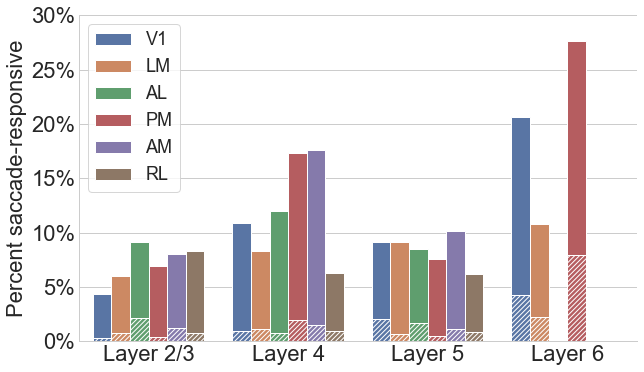

In [242]:
order = sorted(cells["cortical_layer"].unique())

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")
    bar = sns.barplot(data=cells, x="cortical_layer", ci=None, y="is_sr", hue="targeted_structure", ax=ax, order=order, hue_order=AREA_ORDERING)
    patches1 = bar.patches[:]

    legend_handles = ax.legend_.legendHandles
    bar2 = sns.barplot(x=cells["cortical_layer"], ci=None, y=(cells["response_classification"] == -1), hue=cells["targeted_structure"], ax=ax, order=order, hue_order=AREA_ORDERING)

    for patch in bar2.patches:
        if patch not in patches1:
            patch.set_hatch("/////")

    # ax.set_title("SUPPRESSED", fontsize=16)
    # ax.set_xlabel("Cortical layer", fontsize=16)
    ax.set_xlabel("")
    ax.set_xticklabels([f"Layer {l}" for l in order], fontsize=22)
    ax.set_ylabel("Percent saccade-responsive", fontsize=22)
    ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3])
    ax.set_ylim(min(ax.get_yticks()), max(ax.get_yticks()))
    ax.set_yticklabels([f"{tick*100:.0f}%" for tick in ax.get_yticks()])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False) 
    plt.setp(ax.get_yticklabels(), fontsize=22)
    ax.legend(handles=legend_handles, labels=[AREA_ABBREV[area] for area in ax.get_legend_handles_labels()[1]], fontsize=18, frameon=True)
    savefig(fig, "frac_responsive_by_layer_across_areas.png")

(0.000725, 0.0005)

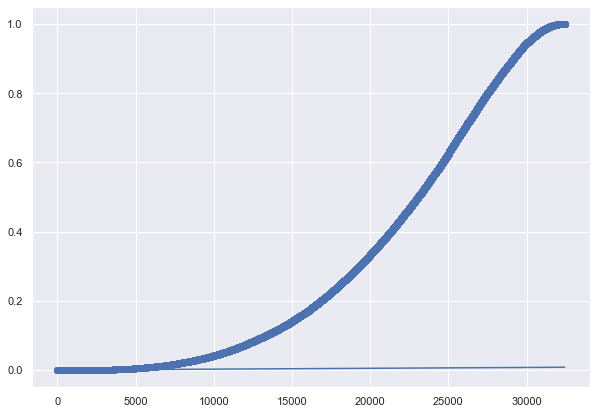

In [311]:
p_vals_sorted = np.sort(cells.p_value)
n = len(p_vals_sorted)
q = 0.008 # Acceptable false discovery rate
i = np.arange(n)

fig, ax = plt.subplots(figsize=(10, 7), facecolor="white")
ax.scatter(i, p_vals_sorted)
ax.plot(i, q*i/n)
max_idx = np.max(np.where(p_vals_sorted < (q*i/n))[0])
p_vals_sorted[max_idx], 5e-4
# ax.set_xlim(0, 4000)

/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator


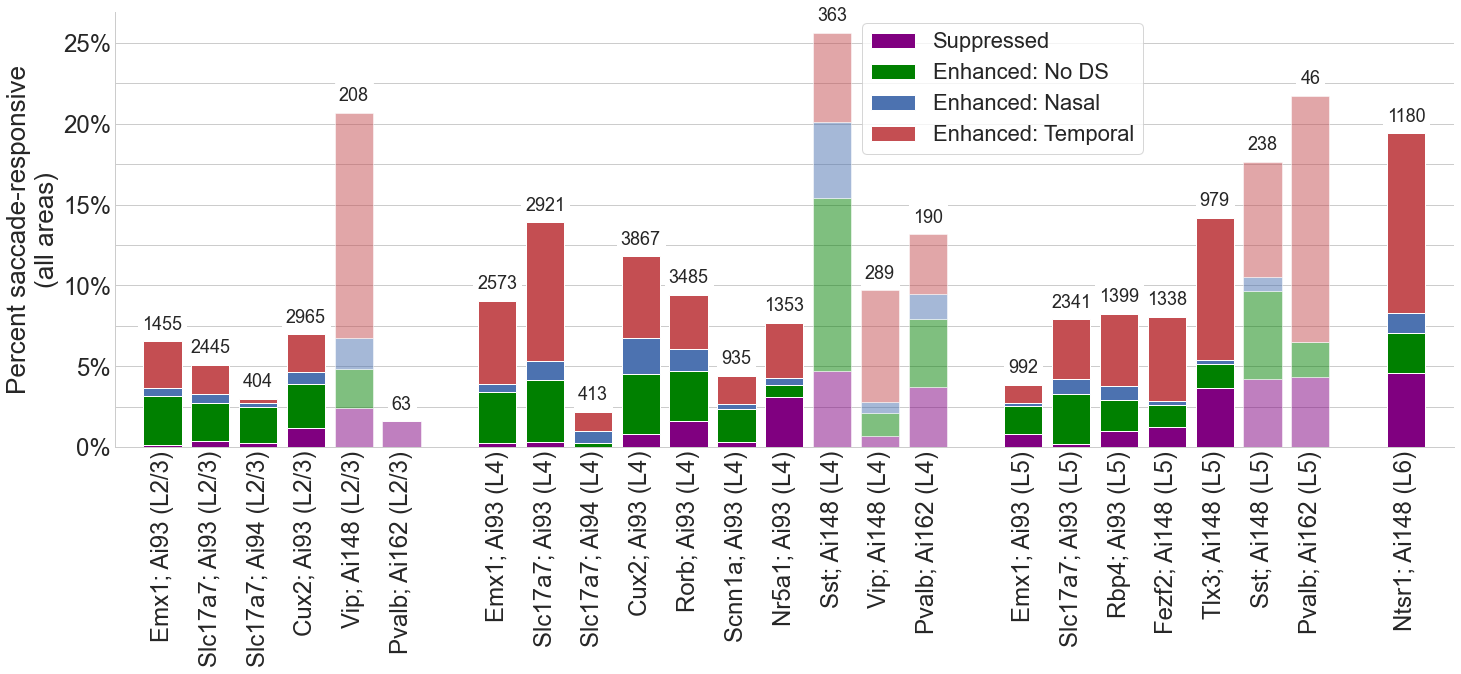

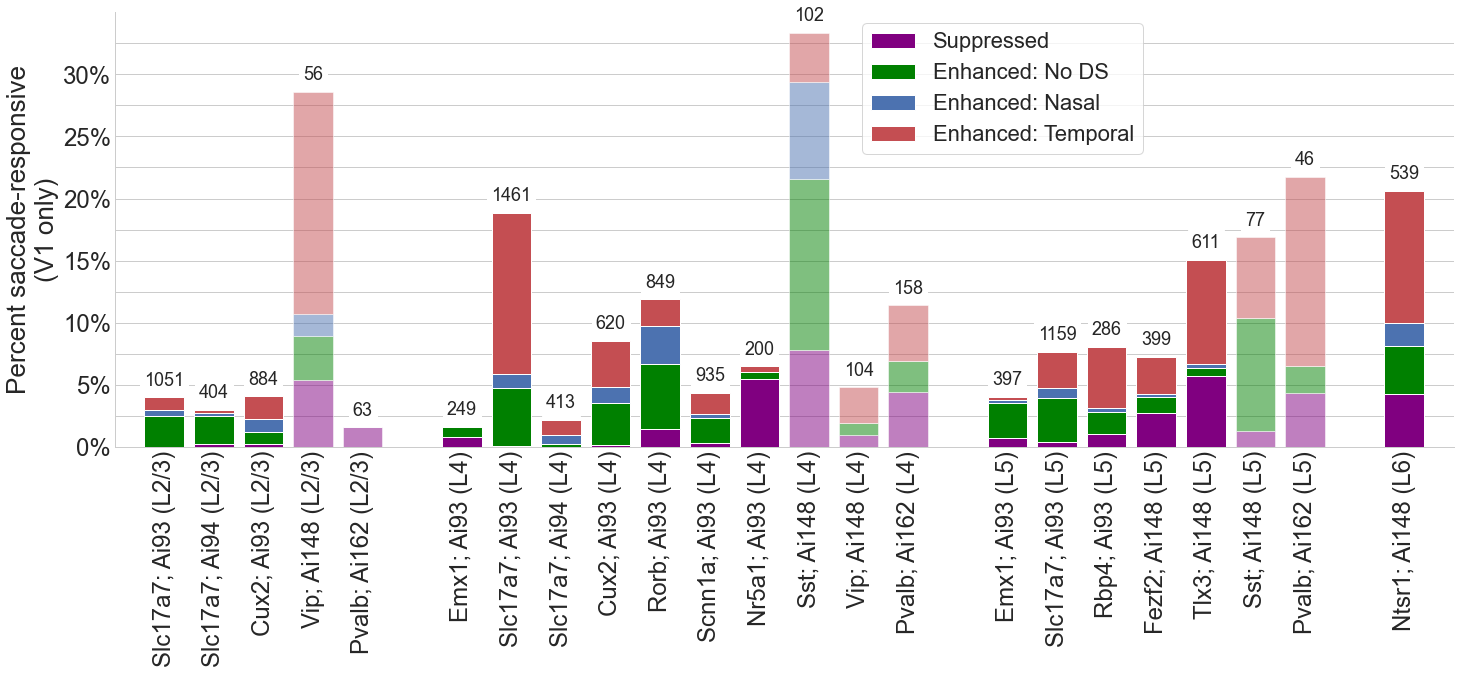

In [297]:
for v1_only in [False, True]: # Whether to plot only V1 cells
    df = cells[cells.targeted_structure == "VISp"] if v1_only else cells
    # df = cells[cells.targeted_structure == "VISp"] if v1_only else cells[cells.targeted_structure != "VISp"]
    cre_and_layer = []
    all_layers = sorted(df["cortical_layer"].unique())
    tick_labels_unique = []
    tick_labels = []
    bar_labels = []

    for i, layer in enumerate(all_layers):
        for cre in CRE_ORDERING:
            mask = (df[CRE_PLOT_KEY] == cre) & (df["cortical_layer"] == layer)
            n_cells = mask.sum()
            if n_cells > 0:
                cre_and_layer.append((cre, layer))
                tick_labels.append(f"{cre} (L{layer})")
                # bar_labels.append(f"{(mask & (cells['is_sr'])).sum()}/{n_cells}")
                bar_labels.append(f"{n_cells}")

        if i < len(all_layers) - 1:
            cre_and_layer.append((None, None))
            tick_labels.append("")
            bar_labels.append("")

    tick_labels_unique = [str(i) for i in range(len(tick_labels))]

    with plt.style.context("seaborn-whitegrid"):
        fig, ax = plt.subplots(figsize=(24, 8), facecolor="white")
        bottom = None
        df = df.groupby(by=[CRE_PLOT_KEY, "cortical_layer"])["sr_label"].value_counts(normalize=True)

        for sr_label, color in SR_LABELS:
            if sr_label == "No response": continue
            heights = []
            excitatory = []

            for cre, layer in cre_and_layer:
                if layer == None:
                    heights.append(0)
                    is_excitatory = True
                else:
                    heights.append(df[cre][layer][sr_label] if sr_label in df[cre][layer] else 0)
                    cre_line = match_cre_line(cre)
                    is_excitatory = cre_line.is_excitatory

                excitatory.append(is_excitatory)

            bar_container = ax.bar(tick_labels_unique, heights, bottom=bottom, label=sr_label, color=color)

            for patch, is_excitatory in zip(bar_container.patches, excitatory):
                if not is_excitatory:
                    # patch.set_hatch("ooo")
                    patch.set_alpha(0.5)

            bottom = heights if bottom is None else bottom + np.array(heights)

        ax.legend(fontsize=22, frameon=True, bbox_to_anchor=(0.55, 1), loc="upper left",  bbox_transform=ax.transAxes)
        ax.set_xticklabels(tick_labels, fontsize=24, rotation=90)
        # plt.setp(ax.get_xticklabels(), )
        ax.set_xlabel("")
        # ax.set_ylim(0, 0.2)
        yticks = np.arange(0, ax.get_ylim()[1]*100, 2.5)
        ax.set_yticks([tick/100 for tick in yticks])
        ax.set_yticklabels([f"{tick:.0f}%" if int(tick) == tick else None for tick in yticks], fontsize=24)
        if v1_only:
            ax.set_ylabel("Percent saccade-responsive\n(V1 only)", fontsize=26)
        else:
            ax.set_ylabel("Percent saccade-responsive\n(all areas)", fontsize=26)
            
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)    
        ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
        ax.xaxis.grid(False) # Remove vertical grid lines
        ax.set_xlim(-1, len(tick_labels))

        if v1_only:
            savefig(fig, "frac_responsive_by_cre_and_layer_v1.png")
        else:
            savefig(fig, "frac_responsive_by_cre_and_layer.png")

In [248]:
# Count the SR cells by cre/layer
cells.groupby(by=[CRE_PLOT_KEY, "cortical_layer"])["is_sr"].value_counts()

cre_abbrev     cortical_layer  is_sr
Cux2; Ai93     2/3             False    2758
                               True      207
               4               False    3411
                               True      456
Emx1; Ai93     2/3             False    1360
                               True       95
               4               False    2340
                               True      233
               5               False     954
                               True       38
Fezf2; Ai148   5               False    1230
                               True      108
Nr5a1; Ai93    4               False    1249
                               True      104
Ntsr1; Ai148   6               False     951
                               True      229
Pvalb; Ai162   2/3             False      62
                               True        1
               4               False     165
                               True       25
               5               False      36
                  

No handles with labels found to put in legend.
/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator


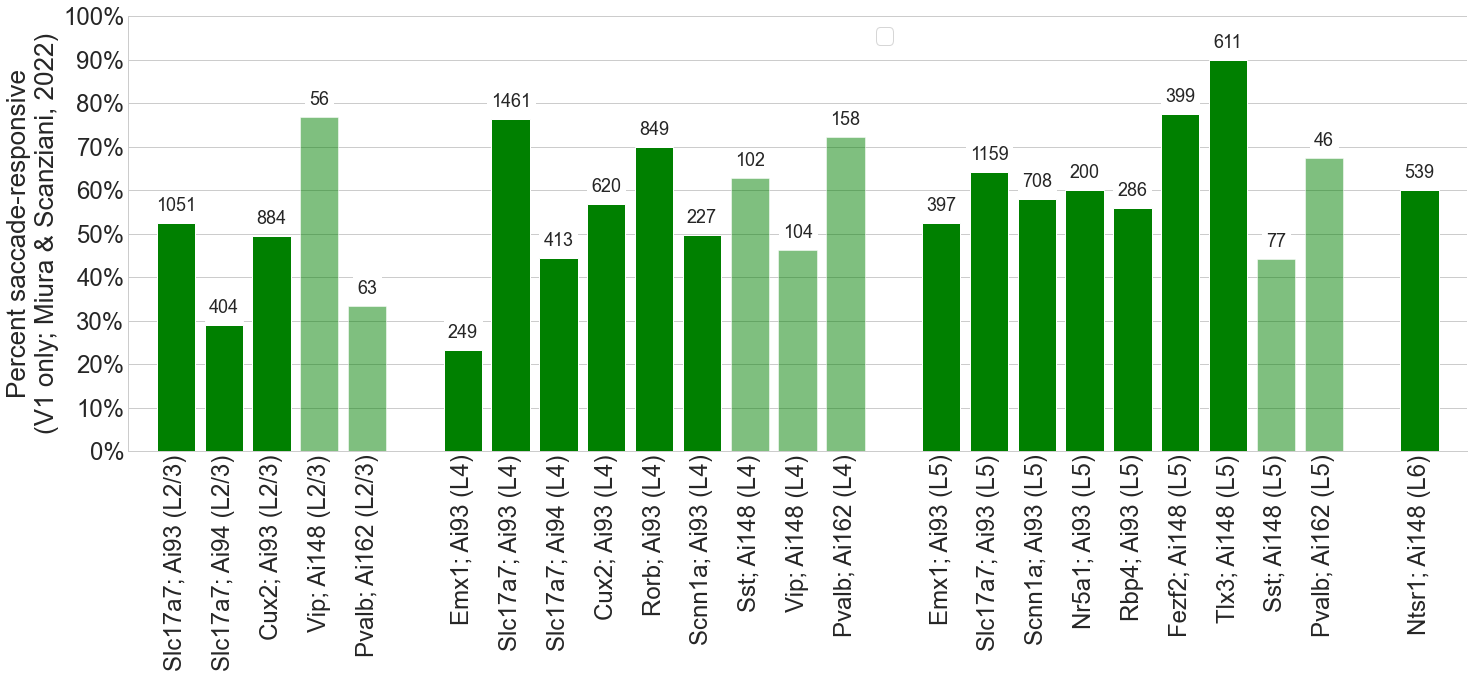

In [51]:
v1_only = True
df = cells[cells.targeted_structure == "VISp"] if v1_only else cells

cre_and_layer = []
all_layers = sorted(df["cortical_layer"].unique())
tick_labels_unique = []
tick_labels = []
bar_labels = []

for i, layer in enumerate(all_layers):
    for cre in CRE_ORDERING:
        mask = (df[CRE_PLOT_KEY] == cre) & (df["cortical_layer"] == layer)
        n_cells = mask.sum()
        if n_cells > 0:
            cre_and_layer.append((cre, layer))
            tick_labels.append(f"{cre} (L{layer})")
            # bar_labels.append(f"{(mask & (cells['is_sr'])).sum()}/{n_cells}")
            bar_labels.append(f"{n_cells}")

    if i < len(all_layers) - 1:
        cre_and_layer.append((None, None))
        tick_labels.append("")
        bar_labels.append("")

tick_labels_unique = [str(i) for i in range(len(tick_labels))]

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(24, 8), facecolor="white")
    bottom = None
    df = df.groupby(by=[CRE_PLOT_KEY, "cortical_layer"])["is_sr_miura"].mean()
    heights = []
    excitatory = []

    for cre, layer in cre_and_layer:
        if layer == None:
            heights.append(0)
            is_excitatory = True
        else:
            heights.append(df[cre][layer] if layer in df[cre] else 0)
            cre_line = match_cre_line(cre)
            is_excitatory = cre_line.is_excitatory

        excitatory.append(is_excitatory)

    bar_container = ax.bar(tick_labels_unique, heights, color="green")

    for patch, is_excitatory in zip(bar_container.patches, excitatory):
        if not is_excitatory:
            # patch.set_hatch("ooo")
            patch.set_alpha(0.5)

    ax.legend(fontsize=22, frameon=True, bbox_to_anchor=(0.55, 1), loc="upper left",  bbox_transform=ax.transAxes)
    ax.set_xticklabels(tick_labels, fontsize=24, rotation=90)
    # plt.setp(ax.get_xticklabels(), )
    ax.set_xlabel("")
    # ax.set_ylim(0, 0.2)
    yticks = np.arange(0, 101, 10)
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick:.0f}%" if int(tick) == tick else None for tick in yticks], fontsize=24)
    # ax.set_ylabel("Percent saccade-responsive (all areas)", fontsize=26)
    if v1_only:
        ax.set_ylabel("Percent saccade-responsive\n(V1 only; Miura & Scanziani, 2022)", fontsize=26)
    else:
        ax.set_ylabel("Percent saccade-responsive\n(all areas; Miura & Scanziani, 2022)", fontsize=26)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
    ax.xaxis.grid(False) # Remove vertical grid lines
    ax.set_xlim(-1, len(tick_labels))
    # savefig(fig, "frac_responsive_by_cre_and_layer.png")

    if v1_only:
        savefig(fig, "frac_responsive_by_cre_and_layer_miura_v1.png")
    else:
        savefig(fig, "frac_responsive_by_cre_and_layer_miura.png")

In [26]:
cells.sr_label_miura.value_counts()

No response           24961
SR                     5696
Enhanced: Temporal     1467
Enhanced: Nasal         318
Name: sr_label_miura, dtype: int64

In [ ]:
cluster_ids = [int(x) for x in cells_and_metrics["cluster_id"].dropna().unique()]
cluster_ids.sort()
cluster_id_to_label = [
    "None", "DG", "SG", "DG-SG", "NS", "DG-NS", "SG-NS", "DG-SG-NS",
    "NM", "DG-NM", "SG-NM", "DG-SG-NM", "NS-NM", "DG-NS-NM", "SG-NS-NM", "DG-SG-NS-NM"
]
cluster_id_to_label = [x.replace("-", "–") for x in cluster_id_to_label] # slightly longer dash
cluster_id_labels = [f"{cluster_id_to_label[x]}" for x in cluster_ids]

with plt.style.context("seaborn-whitegrid"):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(25, 20), facecolor="white")
    axs = axs.flatten()

    for i, layer in enumerate(sorted(cells_and_metrics["cortical_layer"].dropna().unique())):
        # fig, ax = plt.subplots(figsize=(15, 8), facecolor="white")
        ax = axs[i]
        bottom = None
        df = cells_and_metrics[cells_and_metrics["cortical_layer"] == layer].groupby("cluster_id")["sr_label"].value_counts(normalize=True)
        areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

        for sr_label, color in SR_LABELS:
            if sr_label == "No response": continue
            heights = []
            for cluster_id in cluster_ids:
                heights.append(df[cluster_id][sr_label] if sr_label in df[cluster_id] else 0)
            ax.bar(cluster_id_labels, heights, bottom=bottom, label=sr_label, color=color)
            bottom = heights if bottom is None else bottom + np.array(heights)

        if i == 0:
            ax.legend(fontsize=16, frameon=True)
        plt.setp(ax.get_xticklabels(), fontsize=18, rotation=90)
        plt.setp(ax.get_yticklabels(), fontsize=18)
        ax.set_xlabel("")
        # yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
        # ax.set_yticks([tick/100 for tick in yticks])
        ax.set_yticks(ax.get_yticks())
        yticks = ax.get_yticks()
        ax.set_yticklabels([f"{tick*100:.0f}%" for tick in yticks], fontsize=18)
        ax.set_ylabel("Percent saccade-responsive", fontsize=18)

        if i < 2:
            ax.set_xticks([])

        # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}\n({(cells_and_metrics['cluster_id'] == cluster_id).sum()})" for cluster_id in cluster_ids]
        # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}/{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
        bar_labels = [f"{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
        bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['cortical_layer'] == layer)).sum()}" for cluster_id in cluster_ids]
        ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_title(layer, fontsize=18)
    # savefig(fig, "cluster_ids.png")

In [278]:
yticks

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175])

['0%', None, '5%', None, '10%', None, '15%', None]


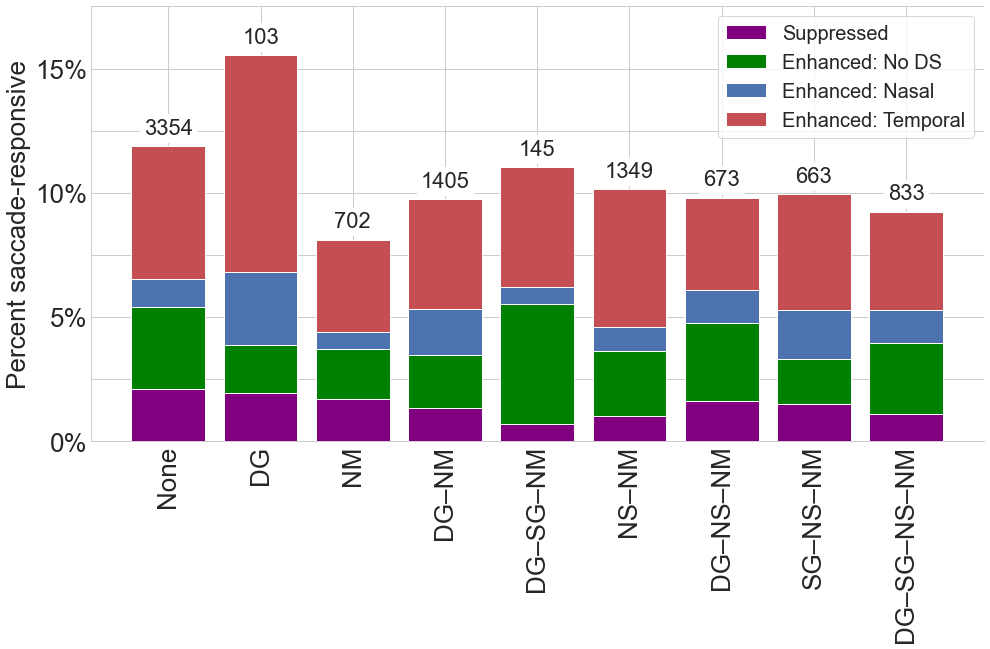

In [285]:
cluster_ids = [int(x) for x in cells_and_metrics["cluster_id"].dropna().unique()]
cluster_ids.sort()
cluster_id_to_label = [
    "None", "DG", "SG", "DG-SG", "NS", "DG-NS", "SG-NS", "DG-SG-NS",
    "NM", "DG-NM", "SG-NM", "DG-SG-NM", "NS-NM", "DG-NS-NM", "SG-NS-NM", "DG-SG-NS-NM"
]
cluster_id_to_label = [x.replace("-", "–") for x in cluster_id_to_label] # slightly longer dash
cluster_id_labels = [f"{cluster_id_to_label[x]}" for x in cluster_ids]

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(16, 8), facecolor="white")
    bottom = None
    df = cells_and_metrics.groupby("cluster_id")["sr_label"].value_counts(normalize=True)
    areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

    for sr_label, color in SR_LABELS:
        if sr_label == "No response": continue
        heights = []
        for cluster_id in cluster_ids:
            heights.append(df[cluster_id][sr_label] if sr_label in df[cluster_id] else 0)
        ax.bar(cluster_id_labels, heights, bottom=bottom, label=sr_label, color=color)
        bottom = heights if bottom is None else bottom + np.array(heights)

    ax.legend(fontsize=20, frameon=True)
    plt.setp(ax.get_xticklabels(), fontsize=26, rotation=90)
    ax.set_xlabel("")
    yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
    ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticklabels([f"{tick:.0f}%" if tick == int(tick) else None for tick in yticks], fontsize=26)
    ax.set_ylabel("Percent saccade-responsive", fontsize=26)

    bar_labels = [f"{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
    ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=22, backgroundcolor="w")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    savefig(fig, "cluster_ids.png")

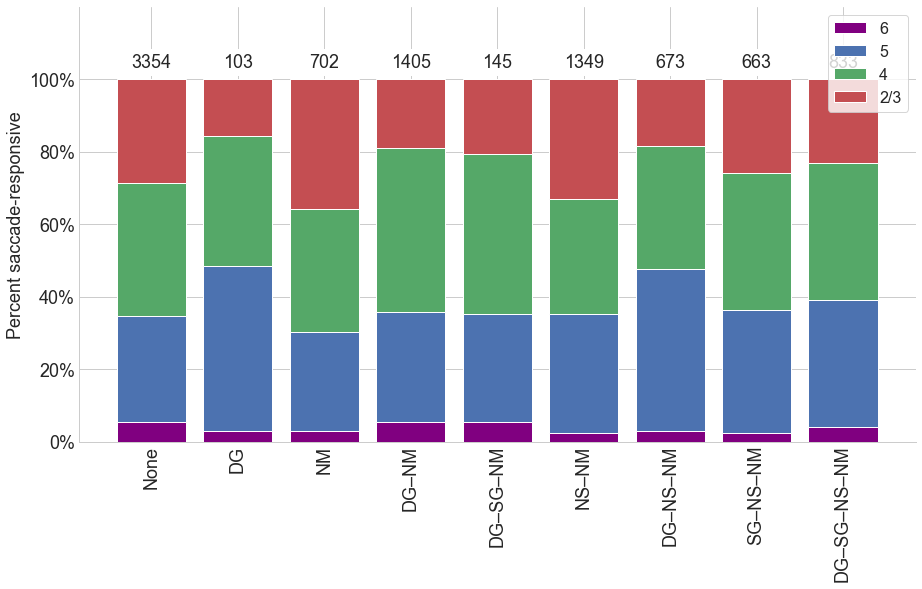

In [124]:
cluster_ids = [int(x) for x in cells_and_metrics["cluster_id"].dropna().unique()]
cluster_ids.sort()
cluster_id_to_label = [
    "None", "DG", "SG", "DG-SG", "NS", "DG-NS", "SG-NS", "DG-SG-NS",
    "NM", "DG-NM", "SG-NM", "DG-SG-NM", "NS-NM", "DG-NS-NM", "SG-NS-NM", "DG-SG-NS-NM"
]
cluster_id_to_label = [x.replace("-", "–") for x in cluster_id_to_label] # slightly longer dash
cluster_id_labels = [f"{cluster_id_to_label[x]}" for x in cluster_ids]

layer_and_color = [
    ("2/3", "r"),
    ("4", "g"),
    ("5", "b"),
    ("6", "purple")
]

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(15, 8), facecolor="white")
    bottom = None
    df = cells_and_metrics.groupby("cluster_id")["cortical_layer"].value_counts(normalize=True)
    areas = [AREA_ABBREV[area] for area in AREA_ORDERING]

    for layer, color in reversed(layer_and_color):
        heights = []
        for cluster_id in cluster_ids:
            heights.append(df[cluster_id][layer] if layer in df[cluster_id] else 0)
        ax.bar(cluster_id_labels, heights, bottom=bottom, label=layer, color=color)
        bottom = heights if bottom is None else bottom + np.array(heights)

    ax.legend(fontsize=16, frameon=True)
    plt.setp(ax.get_xticklabels(), fontsize=18, rotation=90)
    plt.setp(ax.get_yticklabels(), fontsize=18)
    ax.set_xlabel("")
    # yticks = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5]
    # ax.set_yticks([tick/100 for tick in yticks])
    ax.set_yticks(ax.get_yticks())
    yticks = [0, .2 , .4, .6, .8, 1]
    ax.set_yticks(yticks)
    ax.set_yticklabels([f"{tick*100:.0f}%" for tick in yticks], fontsize=18)
    ax.set_ylabel("Percent saccade-responsive", fontsize=18)

    if i < 2:
        ax.set_xticks([])

    # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}\n({(cells_and_metrics['cluster_id'] == cluster_id).sum()})" for cluster_id in cluster_ids]
    # bar_labels = [f"{((cells_and_metrics['cluster_id'] == cluster_id) & (cells_and_metrics['is_sr'])).sum()}/{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
    bar_labels = [f"{(cells_and_metrics['cluster_id'] == cluster_id).sum()}" for cluster_id in cluster_ids]
    ax.bar_label(ax.containers[-1], labels=bar_labels, padding=8, fontsize=18, backgroundcolor="w")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # savefig(fig, "cluster_ids.png")

In [125]:
cells_and_metrics.groupby("cluster_id")["sr_label"].value_counts(normalize=True)

cluster_id  sr_label          
0.0         No response           0.881336
            Enhanced: Temporal    0.053369
            Enhanced: No DS       0.033095
            Suppressed            0.020871
            Enhanced: Nasal       0.011330
1.0         No response           0.844660
            Enhanced: Temporal    0.087379
            Enhanced: Nasal       0.029126
            Enhanced: No DS       0.019417
            Suppressed            0.019417
8.0         No response           0.918803
            Enhanced: Temporal    0.037037
            Enhanced: No DS       0.019943
            Suppressed            0.017094
            Enhanced: Nasal       0.007123
9.0         No response           0.902491
            Enhanced: Temporal    0.044128
            Enhanced: No DS       0.021352
            Enhanced: Nasal       0.018505
            Suppressed            0.013523
11.0        No response           0.889655
            Enhanced: No DS       0.048276
            Enhanced: T

cluster_id  is_sr
0.0         False    2956
            True      398
1.0         False      87
            True       16
Name: is_sr, dtype: int64


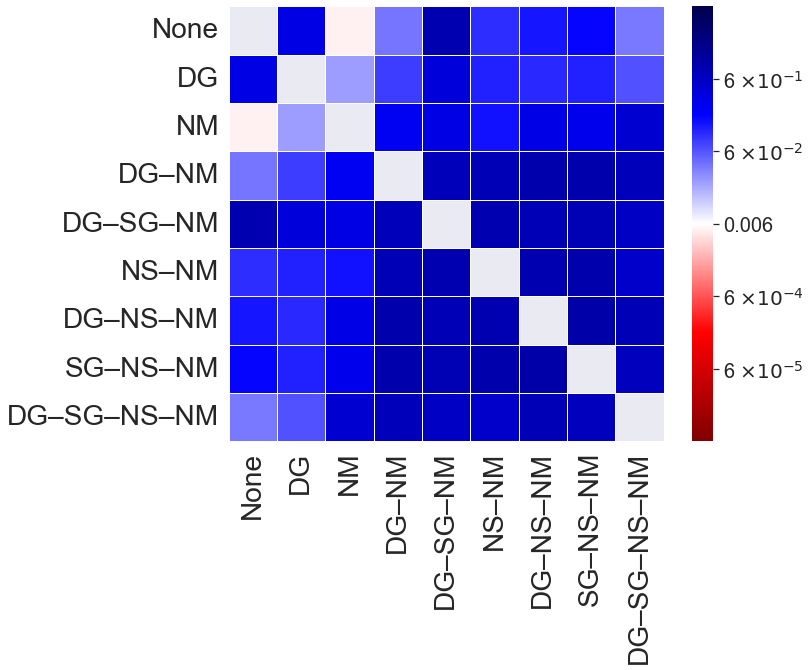

In [130]:
p_matrix = np.zeros((len(cluster_ids), len(cluster_ids)), dtype=float)
counts = cells_and_metrics.groupby("cluster_id")["is_sr"].value_counts()

print(counts.head(4))
        
for i in range(len(cluster_ids)):
    p_matrix[i,i] = np.nan
    for j in range(i+1, len(cluster_ids)):
        observed = [
            [counts[cluster_ids[i]][True], counts[cluster_ids[i]][False]],
            [counts[cluster_ids[j]][True], counts[cluster_ids[j]][False]]
        ]
        p_val = stats.chi2_contingency(observed)[1]
        p_matrix[i,j] = p_matrix[j,i] = p_val

fig, ax = heatmap_log_proba_plot(p_matrix, ticklabels=cluster_id_labels, title="", titlefontsize=28, ticklabelfontsize=28, cbartickfontsize=20, figsize=(10, 8))
savefig(fig, "cluster_ids_proba.png")

In [26]:
print(f"{(cells_and_metrics['responsive_dg'] == True).sum():,} out of {len(cells):,} cells in our dataset were responsive to drifting gratings.")
print(f"{(cells_and_metrics['responsive_ns'] == True).sum():,} out of {len(cells):,} cells in our dataset were responsive to natural scenes.")

10,956 out of 32,442 cells in our dataset were responsive to drifting gratings.
7,744 out of 32,442 cells in our dataset were responsive to natural scenes.


In [27]:
cells.loc[662209107]["session_indices"]

'((627823695, 2), (629789161, 6), (636889229, 5))'

[DSI_pref_tf] Not SR vs. No DS: p = 0.0113
[DSI_pref_tf] Not SR vs. N: p = 0.9407
[DSI_pref_tf] Not SR vs. T: p = 0.1161
[DSI_pref_tf] No DS vs. N: p = 0.1315
[DSI_pref_tf] No DS vs. T: p = 0.0553
[DSI_pref_tf] N vs. T: p = 0.8468


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[g_dsi_dg] Not SR vs. No DS: p = 0.0257
[g_dsi_dg] Not SR vs. N: p = 0.4571
[g_dsi_dg] Not SR vs. T: p = 0.0661
[g_dsi_dg] No DS vs. N: p = 0.2489
[g_dsi_dg] No DS vs. T: p = 0.3810
[g_dsi_dg] N vs. T: p = 0.3865


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[g_osi_dg] Not SR vs. No DS: p = 0.3038
[g_osi_dg] Not SR vs. N: p = 0.0023
[g_osi_dg] Not SR vs. T: p = 0.1217
[g_osi_dg] No DS vs. N: p = 0.0764
[g_osi_dg] No DS vs. T: p = 0.7450
[g_osi_dg] N vs. T: p = 0.0684


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


[lifetime_sparseness_ns] Not SR vs. No DS: p = 0.5708
[lifetime_sparseness_ns] Not SR vs. N: p = 0.0028
[lifetime_sparseness_ns] Not SR vs. T: p = 0.0611
[lifetime_sparseness_ns] No DS vs. N: p = 0.0206
[lifetime_sparseness_ns] No DS vs. T: p = 0.5309
[lifetime_sparseness_ns] N vs. T: p = 0.0136


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


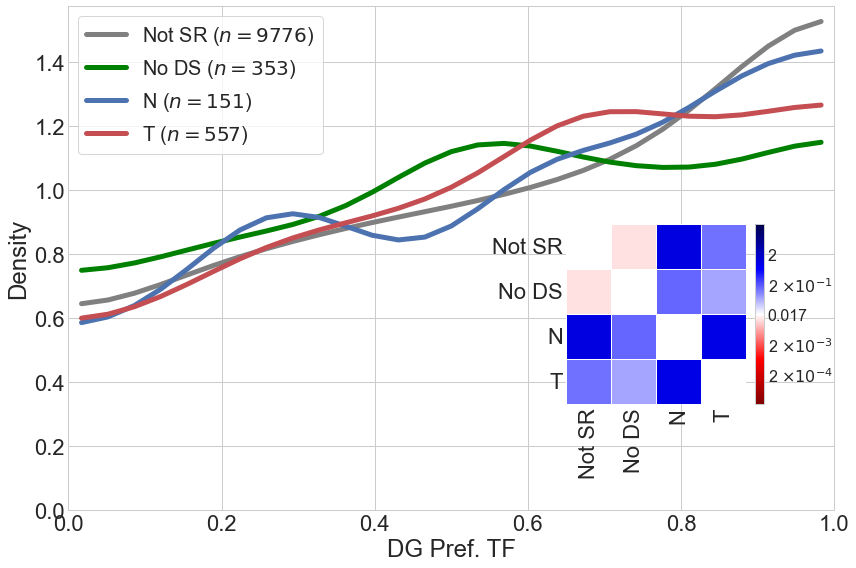

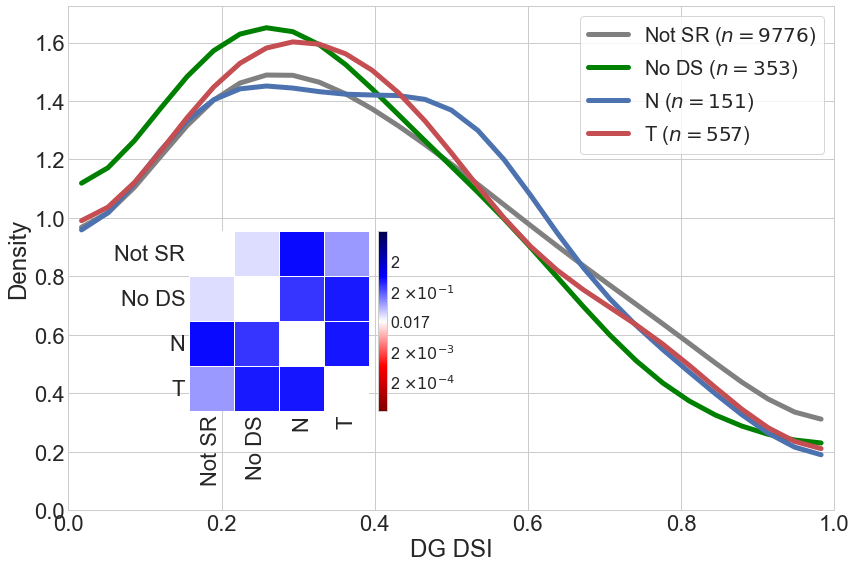

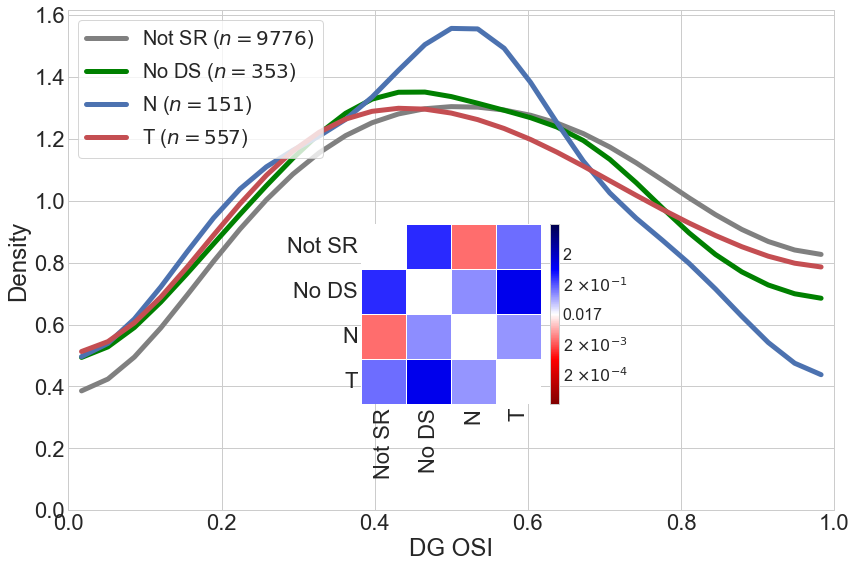

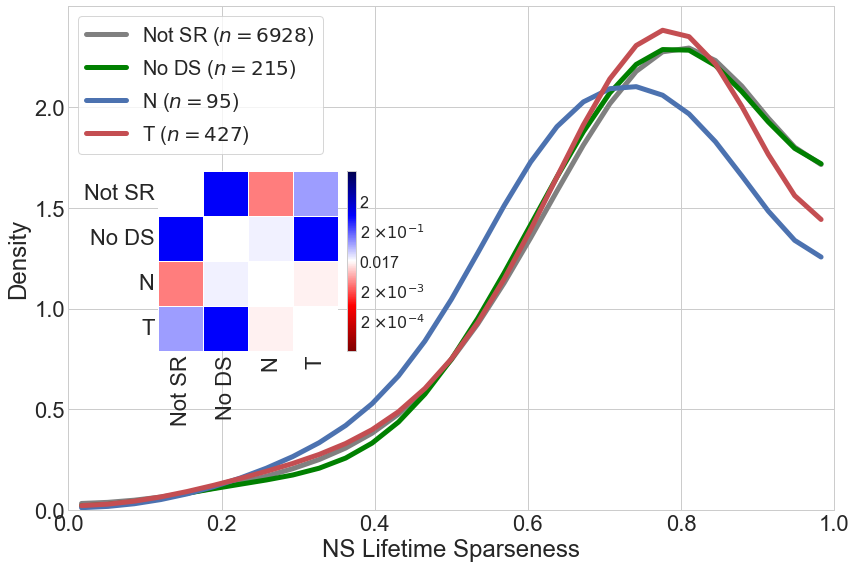

In [143]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes

sr_label_abbrev = {
    "No response": "Not SR",
    "Enhanced: No DS": "No DS",
    "Enhanced: Nasal": "N",
    "Enhanced: Temporal": "T",
}

with plt.style.context("seaborn-whitegrid"):
    for metric, response_metric, plot_label, legend_loc, inset_loc in [
        ("DSI_pref_tf", "responsive_dg", "DG Pref. TF", "upper left", "lower right"),
        ("g_dsi_dg", "responsive_dg", "DG DSI", "upper right", (0.15, 0.15, 0.5, 0.5)),
        ("g_osi_dg", "responsive_dg", "DG OSI", "upper left", "lower center"),
        ("lifetime_sparseness_ns", "responsive_ns", "NS Lifetime Sparseness", "upper left", (0.11, 0.27, 0.5, 0.5))
        # ("image_selectivity_ns", "responsive_ns", "Image selectivity")
    ]:
        if response_metric is not None:
            has_response = (cells_and_metrics[response_metric] == True)
        else:
            has_response = ~cells_and_metrics[metric].isna()
        
        fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")

        bins = np.linspace(0, 1, 30)
        bin_midpoints = (bins[1:] + bins[:-1]) / 2
        filter_window = 3

        dist_and_label = []

        for label, color in SR_LABELS:
            if "Suppressed" in label: continue # Too few suppressed cells to draw meaningful conclusions
            dist = cells_and_metrics[metric].values[has_response & (cells_and_metrics["sr_label"] == label)]
            label = sr_label_abbrev[label]

            dist_and_label.append((dist, label))
            hist, _ = np.histogram(dist, bins=bins, density=True)
            smoothed_curve = ndi.gaussian_filter1d(hist, filter_window)
            # ax.bar(bins[:-1], ndi.gaussian_filter1d(h, filter_window), width=np.mean(np.diff(bins)), color=color, alpha=0.2, lw=0)
            ax.plot(bin_midpoints, smoothed_curve, color=color, linewidth=5, label=f"{label} ($n = {len(dist)}$)")

        ax.legend(fontsize=20, frameon=True, loc=legend_loc)
        ax.set_xlim(0, 1)
        ax.set_ylim(0, ax.get_ylim()[1])
        plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=22)
        ax.set_xlabel(plot_label, fontsize=24)
        ax.set_ylabel("Density", fontsize=24)
        # ax.set_title(f"{has_response.sum():d} cells are responsive ({response_metric})", fontsize=16)
        # fig.tight_layout()
        # savefig(fig, f"metric_{metric}.png")

        if type(inset_loc) is str:
            kwargs = dict(loc=inset_loc, borderpad=8)
        else:
            kwargs = dict(loc="lower left", bbox_to_anchor=inset_loc, bbox_transform=ax.transAxes)
        
        ax_pmatrix = inset_axes(ax, width=2.5, height=3, **kwargs)
        
        p_matrix = np.zeros((len(dist_and_label), len(dist_and_label)), dtype=float)
        
        for i in range(len(dist_and_label)):
            p_matrix[i,i] = np.nan
            for j in range(i+1, len(dist_and_label)):
                a, b = dist_and_label[i][0], dist_and_label[j][0]
                # p_val = stats.ttest_ind(a, b)[1]
                p_val = stats.kstest(a, b)[1]
                p_matrix[i,j] = p_matrix[j,i] = p_val
                print(f"[{metric}] {dist_and_label[i][1]} vs. {dist_and_label[j][1]}: p = {p_val:.4f}")

        heatmap_log_proba_plot(p_matrix, ticklabels=[x[1] for x in dist_and_label], ax=ax_pmatrix, is_inset=True, title="", ticklabelfontsize=22) # title=f"{plot_label}"
        fig.tight_layout()
        savefig(fig, f"metric_{metric}.png")
        # break

[pref_ori_dg] Not SR vs. No DS: p = 0.1356
[pref_ori_dg] Not SR vs. N: p = 0.9261
[pref_ori_dg] Not SR vs. T: p = 0.0344
[pref_ori_dg] No DS vs. N: p = 0.2076
[pref_ori_dg] No DS vs. T: p = 0.8813
[pref_ori_dg] N vs. T: p = 0.1638


/opt/anaconda3/envs/mindscope/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


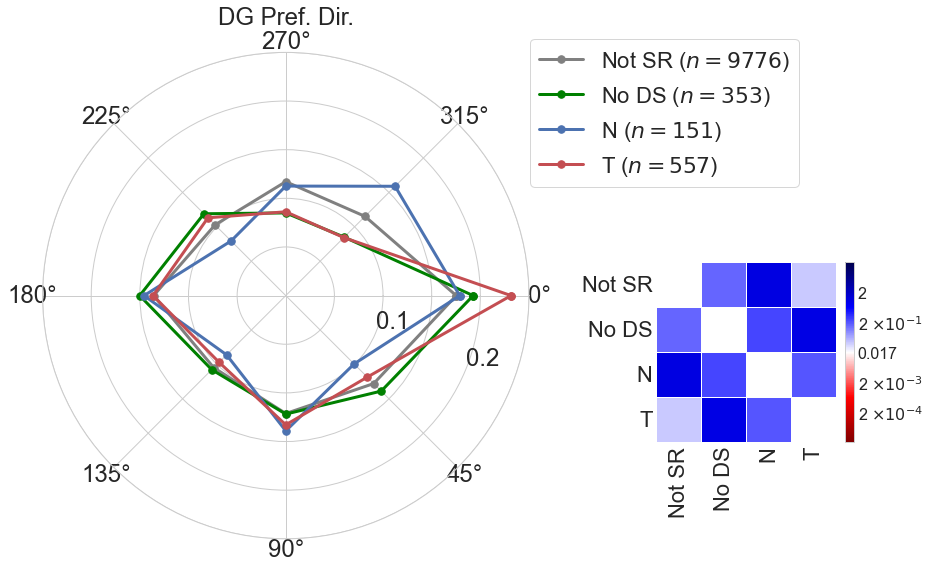

In [158]:
metric = "pref_ori_dg" # called preferred orientation but actually refers to direction of motion
df = cells_and_metrics[metric][cells_and_metrics["responsive_dg"] == True].dropna().groupby(cells_and_metrics["sr_label"]).value_counts(normalize=True).rename("fraction")
angles = sorted(cells_and_metrics["pref_ori_dg"].dropna().unique()) + [360.0]
r = np.arange(0, 2, 0.05)
theta = 2 * np.pi * r

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8), facecolor="white", subplot_kw=dict(projection="polar"))
    ax.set_theta_direction(-1)
    dist_and_label = []

    for sr_label, color in SR_LABELS:
        if "Suppressed" in sr_label: continue
        r = [df[sr_label][0 if angle == 360 else angle] for angle in angles]
        label = sr_label_abbrev[sr_label]
        dist = cells_and_metrics[metric][(cells_and_metrics["responsive_dg"] == True) & (cells_and_metrics["sr_label"] == sr_label)].dropna()
        dist_and_label.append((dist, label))
        ax.plot(np.radians(angles), r, color=color, marker=".", markersize=15, linewidth=3, label=f"{label} ($n = {len(dist)}$)")

    ax.set_rmax(0.25)
    ax.set_rticks([0.05, 0.10, 0.15, 0.20, 0.25])  # Less radial ticks
    ax.set_yticklabels([None, 0.10, None, 0.20, None])  # Less radial ticks
    ax.set_rlabel_position(22.5)  # Move radial labels away from plotted line
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=24)
    ax.grid(True)
    ax.set_title("DG Pref. Dir.", fontsize=24)
    ax.legend(frameon=True, fontsize=22, loc="upper left", bbox_to_anchor=(0.98, 1.05))

    p_matrix = np.zeros((len(dist_and_label), len(dist_and_label)), dtype=float)
        
    for i in range(len(dist_and_label)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(dist_and_label)):
            a, b = dist_and_label[i][0], dist_and_label[j][0]
            # p_val = stats.ttest_ind(a, b)[1]
            p_val = stats.kstest(a, b)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val
            print(f"[{metric}] {dist_and_label[i][1]} vs. {dist_and_label[j][1]}: p = {p_val:.4f}")

    ax_pmatrix = inset_axes(ax, width=2.5, height=3, loc="lower left", bbox_to_anchor=(1.25, 0.15, 0.5, 0.5), bbox_transform=ax.transAxes)
    heatmap_log_proba_plot(p_matrix, ticklabels=[x[1] for x in dist_and_label], title="", ticklabelfontsize=22, ax=ax_pmatrix, is_inset=True)
    # savefig(fig, f"metric_pref_direction_dg_proba.png")

    fig.tight_layout()
    savefig(fig, "metric_pref_direction_dg_polar.png")

    # fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")
    # sns.barplot(data=df.reset_index(), x=metric, y="fraction", hue="sr_label", palette={k: v for (k,v) in SR_LABELS}, hue_order=[x[0] for x in SR_LABELS])
    # ax.set_xticklabels([f"{float(x.get_text()):.0f}°" for x in ax.get_xticklabels()], fontsize=18)
    # plt.setp(ax.get_yticklabels(), fontsize=16)
    # ax.set_xlabel("")
    # ax.set_ylabel("Density", fontsize=16)
    # ax.legend(fontsize=16, frameon=True)

In [148]:
cells_and_metrics["pref_ori_dg"][cells_and_metrics["responsive_dg"] == True].dropna().groupby(cells_and_metrics["sr_label"]).value_counts(normalize=True).rename("fraction")

sr_label            pref_ori_dg
Enhanced: Nasal     0.0            0.178808
                    315.0          0.158940
                    180.0          0.145695
                    90.0           0.139073
                    270.0          0.112583
                    45.0           0.099338
                    135.0          0.086093
                    225.0          0.079470
Enhanced: No DS     0.0            0.192635
                    180.0          0.150142
                    45.0           0.138810
                    90.0           0.121813
                    225.0          0.118980
                    135.0          0.107649
                    270.0          0.084986
                    315.0          0.084986
Enhanced: Temporal  0.0            0.231598
                    180.0          0.136445
                    90.0           0.132855
                    45.0           0.118492
                    225.0          0.113106
                    135.0          0.096948


In [177]:
cells_and_metrics.cre_abbrev.unique()

array(['Cux2; Ai93', 'Sst; Ai148', 'Nr5a1; Ai93', 'Emx1; Ai93',
       'Rbp4; Ai93', 'Rorb; Ai93', 'Slc17a7; Ai93', 'Fezf2; Ai148',
       'Vip; Ai148', 'Tlx3; Ai148', 'Ntsr1; Ai148', 'Scnn1a; Ai93'],
      dtype=object)

In [193]:
is_vip = np.isin(cells_and_metrics.cre_abbrev, "Vip; Ai148")
n_vip = is_vip.sum()
is_vip_responsive = is_vip & (cells_and_metrics["responsive_dg"] == True)
n_vip_responsive = is_vip_responsive.sum()
print(f"{n_vip_responsive}/{n_vip} DG-responsive VIP cells")
cells_and_metrics.groupby([CRE_PLOT_KEY, "sr_label"]).pref_ori_dg.value_counts()

68/318 DG-responsive VIP cells


cre_abbrev  sr_label         pref_ori_dg
Cux2; Ai93  Enhanced: Nasal  270.0          14
                             0.0            13
                             180.0          13
                             315.0          12
                             90.0           11
                                            ..
Vip; Ai148  No response      315.0          20
                             270.0          19
            Suppressed       180.0           3
                             135.0           2
                             270.0           1
Name: pref_ori_dg, Length: 405, dtype: int64

In [198]:
cells_and_metrics.g_osi_dg

589170196    0.277223
517424547    0.488192
589170394    0.431372
589170745    0.506253
589170856    0.504755
               ...   
599566419    0.510331
599566387    0.059552
599566408    0.221309
599566450    0.177016
599566428    0.091371
Name: g_dsi_dg, Length: 21612, dtype: float64

[pref_ori_dg] Not SR vs. Nasal: p = 0.9876
[pref_ori_dg] Not SR vs. Temporal: p = 0.0124
[pref_ori_dg] Not SR vs. No DS: p = 0.4898
[pref_ori_dg] Nasal vs. Temporal: p = 0.1638
[pref_ori_dg] Nasal vs. No DS: p = 0.7955
[pref_ori_dg] Temporal vs. No DS: p = 0.1011


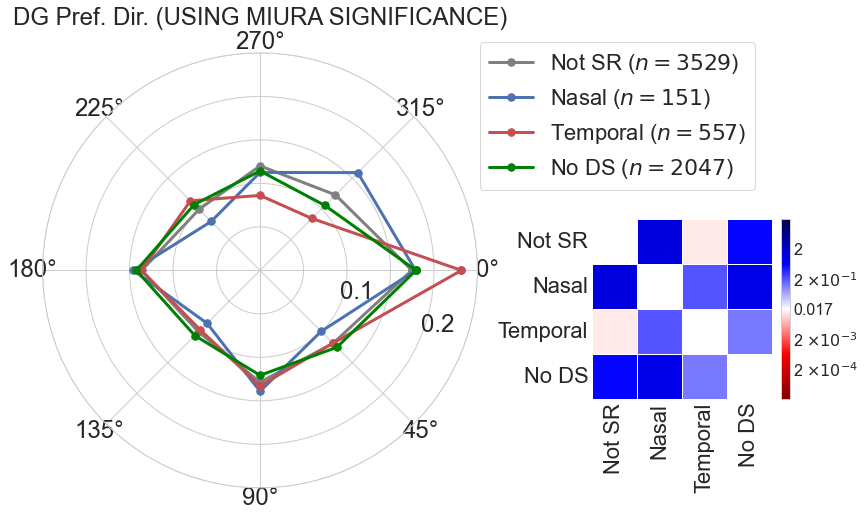

In [208]:
metric = "pref_ori_dg" # called preferred orientation but actually refers to direction of motion
df = cells_and_metrics[(cells_and_metrics["responsive_dg"] == True)]
angles = sorted(df["pref_ori_dg"].dropna().unique()) + [360.0]
r = np.arange(0, 2, 0.05)
theta = 2 * np.pi * r

with plt.style.context("seaborn-whitegrid"):
    fig, ax = plt.subplots(figsize=(12, 8), facecolor="white", subplot_kw=dict(projection="polar"))
    ax.set_theta_direction(-1)
    dist_and_label = []

    def plot(mask, label, color):
        norm = np.count_nonzero(mask)
        r = [np.count_nonzero(mask & (df[metric] == (0 if angle == 360 else angle))) / norm for angle in angles]
        dist = df[metric][mask].dropna()
        dist_and_label.append((dist, label))
        ax.plot(np.radians(angles), r, color=color, marker=".", markersize=15, linewidth=3, label=f"{label} ($n = {len(dist)}$)")

    ds = (df.ranksum_p_by_direction < 0.05)
    sr = (df.wilcoxon_signed_rank_p < 0.05) | ds
    plot(~sr, "Not SR", "gray")
    plot(sr & ds & (df.preferred_direction < 0), "Nasal", "b")
    plot(sr & ds & (df.preferred_direction > 0), "Temporal", "r")
    plot(sr & ~ds, "No DS", "green")
    # plot(sr | ~sr, "All", "black")

    ax.set_rmax(0.25)
    ax.set_rticks([0.05, 0.10, 0.15, 0.20, 0.25])  # Less radial ticks
    ax.set_yticklabels([None, 0.10, None, 0.20, None])  # Less radial ticks
    ax.set_rlabel_position(22.5)  # Move radial labels away from plotted line
    plt.setp((ax.get_xticklabels(), ax.get_yticklabels()), fontsize=24)
    ax.grid(True)
    ax.set_title("DG Pref. Dir. (USING MIURA SIGNIFICANCE)", fontsize=24)
    ax.legend(frameon=True, fontsize=22, loc="upper left", bbox_to_anchor=(0.98, 1.05))

    p_matrix = np.zeros((len(dist_and_label), len(dist_and_label)), dtype=float)
        
    for i in range(len(dist_and_label)):
        p_matrix[i,i] = np.nan
        for j in range(i+1, len(dist_and_label)):
            a, b = dist_and_label[i][0], dist_and_label[j][0]
            # p_val = stats.ttest_ind(a, b)[1]
            p_val = stats.kstest(a, b)[1]
            p_matrix[i,j] = p_matrix[j,i] = p_val
            print(f"[{metric}] {dist_and_label[i][1]} vs. {dist_and_label[j][1]}: p = {p_val:.4f}")

    ax_pmatrix = inset_axes(ax, width=2.5, height=3, loc="lower left", bbox_to_anchor=(1.25, 0.15, 0.5, 0.5), bbox_transform=ax.transAxes)
    heatmap_log_proba_plot(p_matrix, ticklabels=[x[1] for x in dist_and_label], title="", ticklabelfontsize=22, ax=ax_pmatrix, is_inset=True)

In [170]:
p_matrix

array([[       nan, 0.87244243, 0.03139525, 0.89906245],
       [0.87244243,        nan, 0.1530934 , 0.63309214],
       [0.03139525, 0.1530934 ,        nan, 0.07885859],
       [0.89906245, 0.63309214, 0.07885859,        nan]])

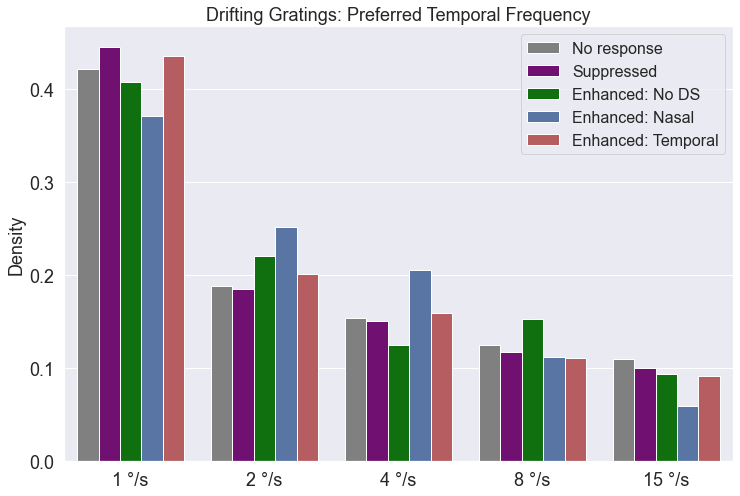

In [179]:
metric = "pref_tf_dg"
y = "fraction"
df = cells_and_metrics[cells_and_metrics["responsive_dg"] == True][metric].dropna().groupby(cells_and_metrics["sr_label"]).value_counts(normalize=True).rename(y).reset_index()

# Get rid of suppressed cells
fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")
sns.barplot(data=df, ax=ax, x=metric, y=y, hue="sr_label", palette={k: v for (k,v) in SR_LABELS}, hue_order=[x[0] for x in SR_LABELS])
ax.set_xticklabels([f"{float(x.get_text()):.0f} °/s" for x in ax.get_xticklabels()], fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("Density", fontsize=18)
ax.set_title("Drifting Gratings: Preferred Temporal Frequency", fontsize=18)
ax.legend(fontsize=16, frameon=True)
# TODO: superimposed trace

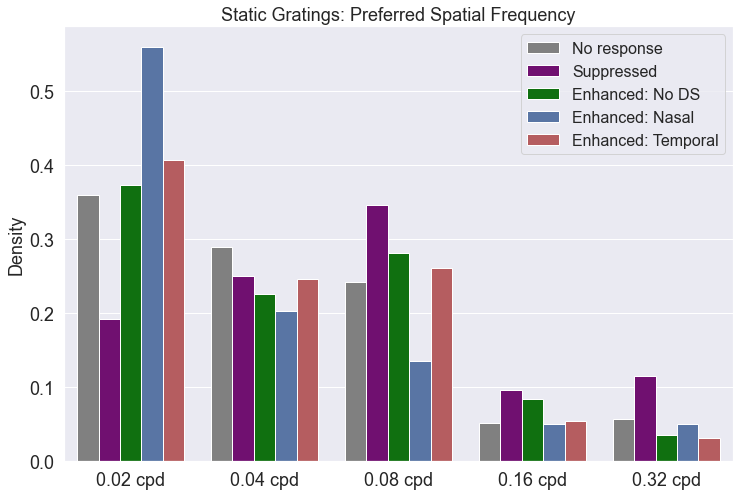

In [18]:
metric = "pref_sf_sg"
y = "fraction"
df = cells_and_metrics[cells_and_metrics["responsive_sg"] == True][metric].dropna().groupby(cells_and_metrics["sr_label"]).value_counts(normalize=True).rename(y).reset_index()

# Get rid of suppressed cells
fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")
sns.barplot(data=df, ax=ax, x=metric, y=y, hue="sr_label", palette={k: v for (k,v) in SR_LABELS}, hue_order=[x[0] for x in SR_LABELS])
ax.set_xticklabels([f"{float(x.get_text()):.2f} cpd" for x in ax.get_xticklabels()], fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.set_title("Static Gratings: Preferred Spatial Frequency", fontsize=18)
ax.set_xlabel("")
ax.set_ylabel("Density", fontsize=18)
ax.legend(fontsize=16, frameon=True)

Index(['cre_line', 'cre_abbrev', 'depth', 'targeted_structure', 'container_id',
       'session_indices', 'response_classification', 'p_value', 'n_left',
       'n_right',
       ...
       'run_stat_dg', 'responsive_rundg', 'run_corr_mean', 'run_corr_A_lw',
       'run_corr_B_lw', 'run_corr_C_lw', 'responsive_run',
       'dg_all_RidgeRegress_CC', 'cluster_id', 'DSI_pref_tf'],
      dtype='object', length=144)

In [47]:
df

,peak_dff_frame,pref_sf_sg,percent
0,0.0,0.08,0.360000
1,0.0,0.04,0.280000
2,0.0,0.02,0.200000
3,0.0,0.16,0.080000
4,0.0,0.32,0.080000
5,1.0,0.08,0.500000
6,1.0,0.04,0.250000
7,1.0,0.02,0.125000
8,1.0,0.16,0.125000
9,2.0,0.08,0.500000


In [64]:
SR_LABELS

[('No response', 'gray'),
 ('Suppressed', 'purple'),
 ('Enhanced: No DS', 'green'),
 ('Enhanced: Nasal', 'b'),
 ('Enhanced: Temporal', 'r')]

<AxesSubplot:xlabel='pref_sf_sg', ylabel='peak_dff_frame'>

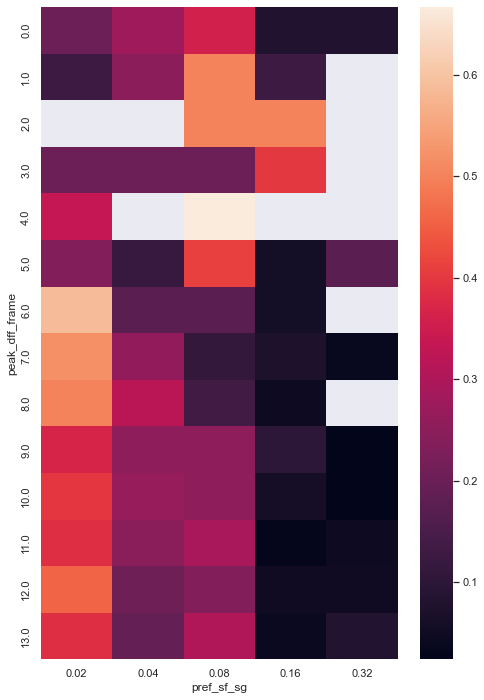

In [77]:
df = cells_and_metrics[(cells_and_metrics["responsive_sg"] == True) & (cells_and_metrics["is_sr"])]["pref_sf_sg"].groupby(cells_and_metrics["peak_dff_frame"]).value_counts(normalize=True).to_frame("percent").reset_index()
# label = SR_LABELS[3][0]
# df = cells_and_metrics[(cells_and_metrics["responsive_sg"] == True) & (cells_and_metrics["sr_label"] == label)]["pref_sf_sg"].groupby(cells_and_metrics["peak_dff_frame"]).value_counts(normalize=True).to_frame("percent").reset_index()
pivot_df = df.pivot("peak_dff_frame", "pref_sf_sg", "percent")
fig, ax = plt.subplots(figsize=(8, 12), facecolor="white")
sns.heatmap(data=pivot_df, ax=ax)

In [78]:
cells_and_metrics[(cells_and_metrics["responsive_sg"] == True) & ~(cells_and_metrics["is_sr"])]["pref_sf_sg"].value_counts(normalize=True)

0.02    0.359806
0.04    0.289831
0.08    0.241646
0.32    0.057385
0.16    0.051332
Name: pref_sf_sg, dtype: float64

<AxesSubplot:xlabel='pref_tf_dg', ylabel='peak_dff_frame'>

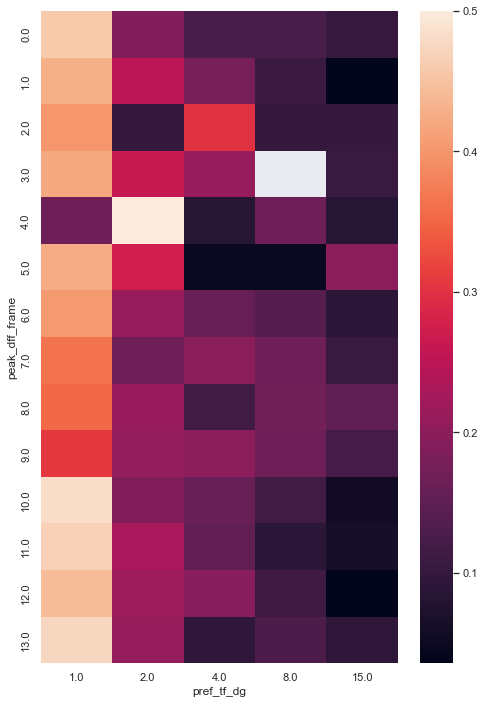

In [79]:
df = cells_and_metrics[(cells_and_metrics["responsive_dg"] == True) & (cells_and_metrics["is_sr"])]["pref_tf_dg"].groupby(cells_and_metrics["peak_dff_frame"]).value_counts(normalize=True).to_frame("percent").reset_index()
# label = SR_LABELS[4][0]
# df = cells_and_metrics[(cells_and_metrics["responsive_dg"] == True) & (cells_and_metrics["sr_label"] == label)]["pref_tf_dg"].groupby(cells_and_metrics["peak_dff_frame"]).value_counts(normalize=True).to_frame("percent").reset_index()
pivot_df = df.pivot("peak_dff_frame", "pref_tf_dg", "percent")
fig, ax = plt.subplots(figsize=(8, 12), facecolor="white")
sns.heatmap(data=pivot_df, ax=ax)

In [80]:
cells_and_metrics[(cells_and_metrics["responsive_dg"] == True) & ~(cells_and_metrics["is_sr"])]["pref_tf_dg"].value_counts(normalize=True)

1.0     0.422361
2.0     0.188421
4.0     0.154051
8.0     0.125307
15.0    0.109861
Name: pref_tf_dg, dtype: float64

In [ ]:
metric = "pref_tf_dg"
y = "fraction"
df = cells_and_metrics[cells_and_metrics["responsive_dg"] == True][metric].dropna().groupby(cells_and_metrics["sr_label"]).value_counts(normalize=True).rename(y).reset_index()
fig, ax = plt.subplots(figsize=(12, 8), facecolor="white")
sns.barplot(data=df, ax=ax, x=metric, y=y, hue="sr_label", palette={k: v for (k,v) in SR_LABELS}, hue_order=[x[0] for x in SR_LABELS])
ax.set_xticklabels([f"{float(x.get_text()):.0f} °/s" for x in ax.get_xticklabels()], fontsize=18)
plt.setp(ax.get_yticklabels(), fontsize=18)
ax.set_xlabel("Saccade ")
ax.set_ylabel("DG Pref. TF (cpd)", fontsize=18)
ax.set_title("", fontsize=18)
ax.legend(fontsize=16, frameon=True)
# TODO: superimposed trace

In [31]:
cells[(cells["targeted_structure"] == "VISrl") & (cells["cortical_layer"] == "2/3")].groupby("cre_line")["response_classification"].value_counts(normalize=True)

cre_line                                           response_classification
Cux2-CreERT2; Camk2a-tTA; Ai93(TITL-GCaMP6f)        0.0                       0.853896
                                                    1.0                       0.129870
                                                   -1.0                       0.016234
Emx1-IRES-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)       0.0                       0.948949
                                                    1.0                       0.051051
Slc17a7-IRES2-Cre; Camk2a-tTA; Ai93(TITL-GCaMP6f)   0.0                       0.892308
                                                    1.0                       0.061538
                                                   -1.0                       0.046154
Name: response_classification, dtype: float64

In [32]:
((cells["response_classification"] == 1) & (cells["preferred_direction"] == 0)).sum()

911

In [33]:
cells["preferred_direction"].value_counts()

 0    30657
 1     1467
-1      318
Name: preferred_direction, dtype: int64

In [34]:
cells["response_classification"].value_counts()

 0.0    29371
 1.0     2696
-1.0      375
Name: response_classification, dtype: int64